# Introduction

This is an initial Exploratory Data Analysis for the [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting) competition with the powers of [tidy R](http://tidyverse.org/) and [ggplot2](http://ggplot2.tidyverse.org/).

The aim of this challenge is to predict the future numbers of restaurant visitors. This makes it a Time Series Forecasting problem. The data was collected from Japanese restaurants. As we will see, the data set is small and easily accessible without requiring much memory or computing power. Therefore, this competition is particularly suited for beginners.

The [data](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data) comes in the shape of 8 relational files which are derived from two separate Japanese websites that collect user information: "Hot Pepper Gourmet (hpg): similar to Yelp" (search and reserve) and "AirREGI / Restaurant Board (air): similar to Square" (reservation control and cash register). The training data is based on the time range of Jan 2016 - most of Apr 2017, while the test set includes the last week of Apr plus May 2017. The test data "intentionally spans a holiday week in Japan called the 'Golden Week.' The [data description](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data) further notes that: "There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed."

Those are the individual files:

- **air_visit_data.csv**: historical visit data for the *air* restaurants. This is essentially the main training data set.

- **air_reserve.csv** / **hpg_reserve.csv**: reservations made through the *air* / *hpg* systems.

- **air_store_info.csv** / **hpg_store_info.csv**: details about the *air* / *hpg* restaurants including genre and location.

- **store_id_relation.csv**: connects the *air* and *hpg* ids

- **date_info.csv**: essentially flags the Japanese holidays.

- **sample_submission.csv**: serves as the *test* set. The *id* is formed by combining the *air* id with the visit date.

## Load libraries

We load a range of libraries for general data wrangling and general visualisation together with more specialised tools.


In [1]:
# general visualisation
library('ggplot2') # visualisation
library('scales') # visualisation
library('grid') # visualisation
library('gridExtra') # visualisation
library('RColorBrewer') # visualisation
library('corrplot') # visualisation

# general data manipulation
library('dplyr') # data manipulation
library('readr') # input/output
library('data.table') # data manipulation
library('tibble') # data wrangling
library('tidyr') # data wrangling
library('stringr') # string manipulation
library('forcats') # factor manipulation

# specific visualisation
library('ggfortify') # visualisation
library('ggrepel') # visualisation
library('ggridges') # visualisation
library('ggExtra') # visualisation
library('ggforce') # visualisation

# specific data manipulation
library('lazyeval') # data wrangling
library('broom') # data wrangling
library('purrr') # string manipulation

# Date plus forecast
library('lubridate') # date and time
library('timeDate') # date and time
library('tseries') # time series analysis
library('forecast') # time series analysis
library('prophet') # time series analysis

# Maps / geospatial
library('geosphere') # geospatial locations
library('leaflet') # maps
library('leaflet.extras') # maps
library('maps') # maps

corrplot 0.84 loaded

Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'readr'

The following object is masked from 'package:scales':

    col_factor


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last


Attaching package: 'purrr'

The following objects are masked from 'package:lazyeval':

    is_atomic, is_formula

The following object is masked from 'package:data.table':

    transpose

The following object is masked from 'package:scales':

    discard


Attaching package: 'lubridate'

The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from 'package:base':

    d


## Helper functions

We use the *multiplot* function, courtesy of [R Cookbooks](http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/) to create multi-panel plots. We also make use of a brief helper function to compute binomial confidence intervals.

In [2]:
# Define multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

#function to extract binomial confidence levels
get_binCI <- function(x,n) as.list(setNames(binom.test(x,n)$conf.int, c("lwr", "upr")))

## Load data

We use *data.table's* fread function to speed up reading in the data:


In [3]:
air_visits <- as.tibble(fread('input/air_visit_data.csv'))
air_reserve <- as.tibble(fread('input/air_reserve.csv'))
hpg_reserve <- as.tibble(fread('input/hpg_reserve.csv'))
air_store <- as.tibble(fread('input/air_store_info.csv'))
hpg_store <- as.tibble(fread('input/hpg_store_info.csv'))
holidays <- as.tibble(fread('input/date_info.csv'))
store_ids <- as.tibble(fread('input/store_id_relation.csv'))
test <- as.tibble(fread('input/sample_submission.csv'))

In [4]:
summary(air_visits)

glimpse(air_visits)
air_visits %>% distinct(air_store_id) %>% nrow()

 air_store_id        visit_date           visitors     
 Length:252108      Length:252108      Min.   :  1.00  
 Class :character   Class :character   1st Qu.:  9.00  
 Mode  :character   Mode  :character   Median : 17.00  
                                       Mean   : 20.97  
                                       3rd Qu.: 29.00  
                                       Max.   :877.00  

Observations: 252,108
Variables: 3
$ air_store_id <chr> "air_ba937bf13d40fb24", "air_ba937bf13d40fb24", "air_b...
$ visit_date   <chr> "2016-01-13", "2016-01-14", "2016-01-15", "2016-01-16"...
$ visitors     <int> 25, 32, 29, 22, 6, 9, 31, 21, 18, 26, 21, 11, 24, 21, ...


[1] 829

We find that this file contains the *visitors* numbers for each *visit\_date* and *air\_store\_id*. The date feature should be transformed into a time-series format. There are 829 different stores, which is a small data set:

In [5]:
air_visits %>% distinct(air_store_id) %>% nrow()

[1] 829

In [6]:
## Air Reserve
summary(air_reserve)
glimpse(air_reserve)

 air_store_id       visit_datetime     reserve_datetime   reserve_visitors 
 Length:92378       Length:92378       Length:92378       Min.   :  1.000  
 Class :character   Class :character   Class :character   1st Qu.:  2.000  
 Mode  :character   Mode  :character   Mode  :character   Median :  3.000  
                                                          Mean   :  4.482  
                                                          3rd Qu.:  5.000  
                                                          Max.   :100.000  

Observations: 92,378
Variables: 4
$ air_store_id     <chr> "air_877f79706adbfb06", "air_db4b38ebe7a7ceff", "a...
$ visit_datetime   <chr> "2016-01-01 19:00:00", "2016-01-01 19:00:00", "201...
$ reserve_datetime <chr> "2016-01-01 16:00:00", "2016-01-01 19:00:00", "201...
$ reserve_visitors <int> 1, 3, 6, 2, 5, 2, 4, 2, 2, 2, 3, 3, 2, 6, 7, 41, 1...


We find that the *air* reservations include the *date* and *time* of the reservation, as well as those of the visit. We have reservation numbers for 314 *air* stores:

In [7]:
air_reserve %>% distinct(air_store_id) %>% nrow()

## HPG Reserve

summary(hpg_reserve)

glimpse(hpg_reserve)

[1] 314

 hpg_store_id       visit_datetime     reserve_datetime   reserve_visitors 
 Length:2000320     Length:2000320     Length:2000320     Min.   :  1.000  
 Class :character   Class :character   Class :character   1st Qu.:  2.000  
 Mode  :character   Mode  :character   Mode  :character   Median :  3.000  
                                                          Mean   :  5.074  
                                                          3rd Qu.:  6.000  
                                                          Max.   :100.000  

Observations: 2,000,320
Variables: 4
$ hpg_store_id     <chr> "hpg_c63f6f42e088e50f", "hpg_dac72789163a3f47", "h...
$ visit_datetime   <chr> "2016-01-01 11:00:00", "2016-01-01 13:00:00", "201...
$ reserve_datetime <chr> "2016-01-01 09:00:00", "2016-01-01 06:00:00", "201...
$ reserve_visitors <int> 1, 3, 2, 5, 13, 2, 2, 2, 2, 6, 2, 2, 2, 2, 5, 4, 2...


The *hpg* reservations file follows the same structure as the corresponding *air* file. We have reservation numbers for 13325 *hpg* stores:

In [8]:
hpg_reserve %>% distinct(hpg_store_id) %>% nrow()
## Air Store
summary(air_store)
glimpse(air_store)

[1] 13325

 air_store_id       air_genre_name     air_area_name         latitude    
 Length:829         Length:829         Length:829         Min.   :33.21  
 Class :character   Class :character   Class :character   1st Qu.:34.70  
 Mode  :character   Mode  :character   Mode  :character   Median :35.66  
                                                          Mean   :35.65  
                                                          3rd Qu.:35.69  
                                                          Max.   :44.02  
   longitude    
 Min.   :130.2  
 1st Qu.:135.3  
 Median :139.7  
 Mean   :137.4  
 3rd Qu.:139.8  
 Max.   :144.3  

Observations: 829
Variables: 5
$ air_store_id   <chr> "air_0f0cdeee6c9bf3d7", "air_7cc17a324ae5c7dc", "air...
$ air_genre_name <chr> "Italian/French", "Italian/French", "Italian/French"...
$ air_area_name  <chr> "Hy艒go-ken K艒be-shi Kumoid艒ri", "Hy艒go-ken K艒be-shi ...
$ latitude       <dbl> 34.69512, 34.69512, 34.69512, 34.69512, 35.65807, 35...
$ longitude      <dbl> 135.1979, 135.1979, 135.1979, 135.1979, 139.7516, 13...


We find that the *air\_store* info includes the name of the particular cuisine along with the name of the area.

In [9]:
## HPG Store
summary(hpg_store)

glimpse(hpg_store)

 hpg_store_id       hpg_genre_name     hpg_area_name         latitude    
 Length:4690        Length:4690        Length:4690        Min.   :33.31  
 Class :character   Class :character   Class :character   1st Qu.:34.69  
 Mode  :character   Mode  :character   Mode  :character   Median :35.66  
                                                          Mean   :35.81  
                                                          3rd Qu.:35.70  
                                                          Max.   :43.77  
   longitude    
 Min.   :130.3  
 1st Qu.:135.5  
 Median :139.5  
 Mean   :137.7  
 3rd Qu.:139.7  
 Max.   :143.7  

Observations: 4,690
Variables: 5
$ hpg_store_id   <chr> "hpg_6622b62385aec8bf", "hpg_e9e068dd49c5fa00", "hpg...
$ hpg_genre_name <chr> "Japanese style", "Japanese style", "Japanese style"...
$ hpg_area_name  <chr> "T艒ky艒-to Setagaya-ku Taishid艒", "T艒ky艒-to Setagaya-...
$ latitude       <dbl> 35.64367, 35.64367, 35.64367, 35.64367, 35.64367, 35...
$ longitude      <dbl> 139.6682, 139.6682, 139.6682, 139.6682, 139.6682, 13...


Again, the *hpg\_store* info follows the same structure as the *air* info. Here the *genre\_name* includes the word *style*. It's worth checking whether the same is true for the *air* data or whether it just refers to the specific "Japanese style". There are 4690 different *hpg\_store\_ids*, which are significantly fewer than we have reservation data for.

In [10]:
## Holidays

summary(holidays)

glimpse(holidays)

 calendar_date      day_of_week         holiday_flg    
 Length:517         Length:517         Min.   :0.0000  
 Class :character   Class :character   1st Qu.:0.0000  
 Mode  :character   Mode  :character   Median :0.0000  
                                       Mean   :0.0677  
                                       3rd Qu.:0.0000  
                                       Max.   :1.0000  

Observations: 517
Variables: 3
$ calendar_date <chr> "2016-01-01", "2016-01-02", "2016-01-03", "2016-01-04...
$ day_of_week   <chr> "Friday", "Saturday", "Sunday", "Monday", "Tuesday", ...
$ holiday_flg   <int> 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...


We called the *date\_info* file *holidays*, because that's essentially the information it contains. Holidays are encoded as binary flags in integer format. This should become a logical binary feature for exploration purposes.

In [11]:
## Store IDs

summary(store_ids)

glimpse(store_ids)

 air_store_id       hpg_store_id      
 Length:150         Length:150        
 Class :character   Class :character  
 Mode  :character   Mode  :character  

Observations: 150
Variables: 2
$ air_store_id <chr> "air_63b13c56b7201bd9", "air_a24bf50c3e90d583", "air_c...
$ hpg_store_id <chr> "hpg_4bc649e72e2a239a", "hpg_c34b496d0305a809", "hpg_c...


In [12]:
## Missing values
sum(is.na(air_visits))
sum(is.na(air_reserve))
sum(is.na(hpg_reserve))
sum(is.na(air_store))
sum(is.na(hpg_store))
sum(is.na(holidays))
sum(is.na(store_ids))
sum(is.na(test))

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

## Reformating features

We change the formatting of the date/time features and also reformat a few features to logical and factor variables for exploration purposes.

In [13]:
air_visits <- air_visits %>%
  mutate(visit_date = ymd(visit_date))

air_reserve <- air_reserve %>%
  mutate(visit_datetime = ymd_hms(visit_datetime),
         reserve_datetime = ymd_hms(reserve_datetime))

hpg_reserve <- hpg_reserve %>%
  mutate(visit_datetime = ymd_hms(visit_datetime),
         reserve_datetime = ymd_hms(reserve_datetime))

air_store <- air_store %>%
  mutate(air_genre_name = as.factor(air_genre_name),
         air_area_name = as.factor(air_area_name))

hpg_store <- hpg_store %>%
  mutate(hpg_genre_name = as.factor(hpg_genre_name),
         hpg_area_name = as.factor(hpg_area_name))

holidays <- holidays %>%
  mutate(holiday_flg = as.logical(holiday_flg),
         date = ymd(calendar_date))

# Individual feature visualisations

Here we have a first look at the distributions of the feature in our individual data files before combining them for a more detailed analysis. This inital visualisation will be the foundation on which we build our analysis.

## Air Visits

We start with the number of visits to the *air* restaurants. Here we plot the total number of visitors per day over the full *training* time range together with the median visitors per day of the week and month of the year:

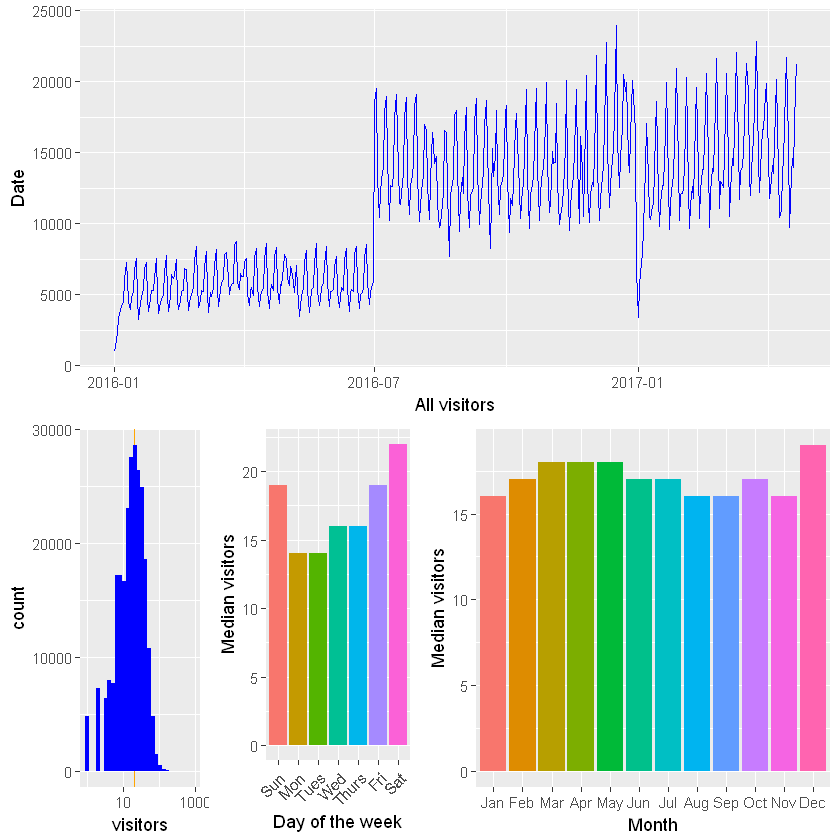

In [14]:
p1 <- air_visits %>%
  group_by(visit_date) %>%
  summarise(all_visitors = sum(visitors)) %>%
  ggplot(aes(visit_date,all_visitors)) +
  geom_line(col = "blue") +
  labs(x = "All visitors", y = "Date")

p2 <- air_visits %>%
  ggplot(aes(visitors)) +
  geom_vline(xintercept = 20, color = "orange") +
  geom_histogram(fill = "blue", bins = 30) +
  scale_x_log10()

p3 <- air_visits %>%
  mutate(wday = wday(visit_date, label = TRUE)) %>%
  group_by(wday) %>%
  summarise(visits = median(visitors)) %>%
  ggplot(aes(wday, visits, fill = wday)) +
  geom_col() +
  theme(legend.position = "none", axis.text.x  = element_text(angle=45, hjust=1, vjust=0.9)) +
  labs(x = "Day of the week", y = "Median visitors")
  
p4 <- air_visits %>%
  mutate(month = month(visit_date, label = TRUE)) %>%
  group_by(month) %>%
  summarise(visits = median(visitors)) %>%
  ggplot(aes(month, visits, fill = month)) +
  geom_col() +
  theme(legend.position = "none") +
  labs(x = "Month", y = "Median visitors")

layout <- matrix(c(1,1,1,1,2,3,4,4),2,4,byrow=TRUE)
multiplot(p1, p2, p3, p4, layout=layout)

We find:

- There is an interesting long-term step structure in the overall time series. This might be related to new restaurants being added to the data base. In addition, we already see a periodic pattern that most likely corresponds to a weekly cycle.

- The number of guests per visit per restaurant per day peaks at around 20 (the orange line). The distribution extends up to 100 and, in rare cases, beyond.

- Friday and the weekend appear to be the most popular days; which is to be expected. Monday and Tuesday have the lowest numbers of average visitors.

- Also during the year there is a certain amount of variation. Dec appears to be the most popular month for restaurant visits. The period of Mar - May is consistently busy.


We will be forecasting for the last week of April plus May 2017, so let's look at this time range in our 2016 training data:

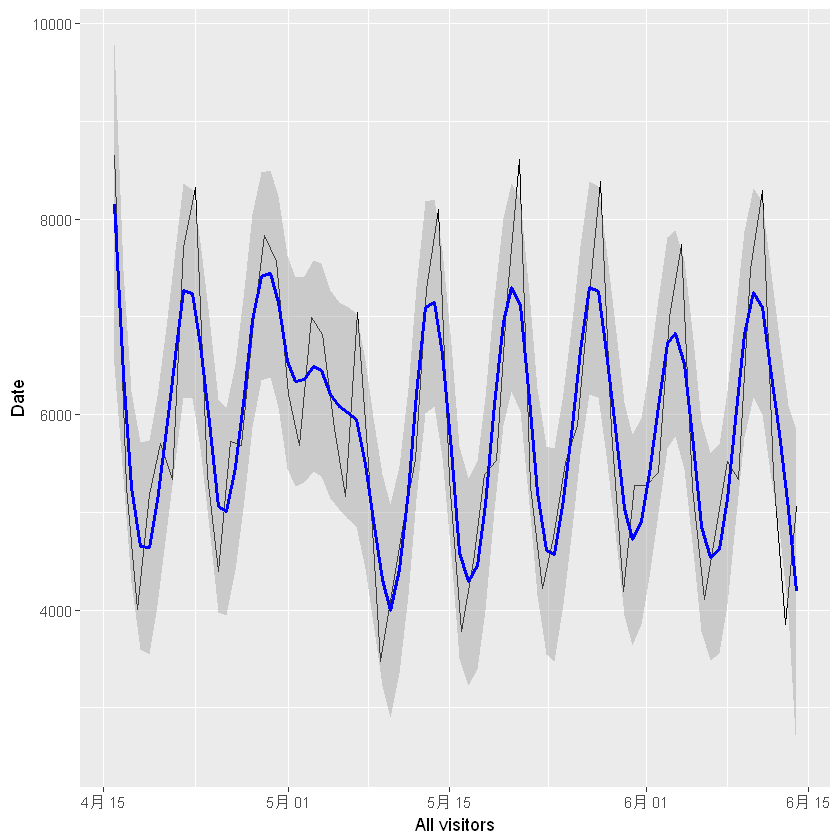

In [15]:
air_visits %>%
  filter(visit_date > ymd("2016-04-15") & visit_date < ymd("2016-06-15")) %>%
  group_by(visit_date) %>%
  summarise(all_visitors = sum(visitors)) %>%
  ggplot(aes(visit_date,all_visitors)) +
  geom_line() +
  geom_smooth(method = "loess", color = "blue", span = 1/7) +
  labs(x = "All visitors", y = "Date")

Here, the black line is the date and the blue line corresponds to a smoothing fit with a corresponding grey confidence area. We see again the weekly period and also the impact of the aforementioned [Golden Week](https://en.wikipedia.org/wiki/Golden_Week_(Japan)), which in 2016 happened between Apr 29 and May 5.


## Air Reservations

Let's see how our reservations data compares to the actual visitor numbers. We start with the *air* restaurants and visualise their visitor volume through reservations for each day, alongside the hours of these visits and the time between making a reservation and visiting the restaurant:

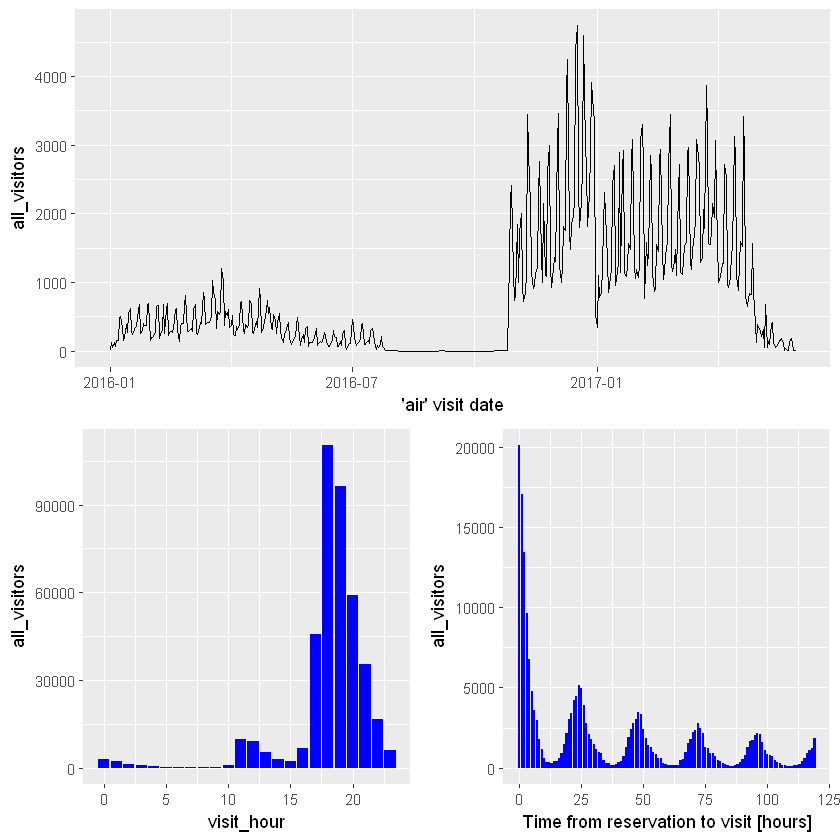

In [16]:
foo <- air_reserve %>%
  mutate(reserve_date = date(reserve_datetime),
         reserve_hour = hour(reserve_datetime),
         reserve_wday = wday(reserve_datetime, label = TRUE),
         visit_date = date(visit_datetime),
         visit_hour = hour(visit_datetime),
         visit_wday = wday(visit_datetime, label = TRUE),
         diff_hour = time_length(visit_datetime - reserve_datetime, unit = "hour"),
         diff_day = time_length(visit_datetime - reserve_datetime, unit = "day")
         )

p1 <- foo %>%
  group_by(visit_date) %>%
  summarise(all_visitors = sum(reserve_visitors)) %>%
  ggplot(aes(visit_date, all_visitors)) +
  geom_line() +
  labs(x = "'air' visit date")

p2 <- foo %>%
  group_by(visit_hour) %>%
  summarise(all_visitors = sum(reserve_visitors)) %>%
  ggplot(aes(visit_hour, all_visitors)) +
  geom_col(fill = "blue")

p3 <- foo %>%
  filter(diff_hour < 24*5) %>%
  group_by(diff_hour) %>%
  summarise(all_visitors = sum(reserve_visitors)) %>%
  ggplot(aes(diff_hour, all_visitors)) +
  geom_col(fill = "blue") +
  labs(x = "Time from reservation to visit [hours]")

layout <- matrix(c(1,1,2,3),2,2,byrow=TRUE)
multiplot(p1, p2, p3, layout=layout)

We find:

- There were much fewer reservations made in 2016 through the *air* system; even none at all for a long stretch of time. The volume only increased during the end of that year. In 2017 the visitor numbers stayed strong. The artifical decline we see after the first quarter is most likely related to these reservations being at the end of the *training* time frame, which means that long-term reservations would not be part of this data set.

- Reservations are made typically for the dinner *hours* in the evening.

- The time, here shown in hours, between making a reservation and visiting the restaurant follow a nice 24-hour pattern. The most popular strategy is to reserve a couple of hours before the visit, but if the reservation is made more in advance then it seems to be common to book a table in the evening for one of the next evenings. This plot is truncated to show this pattern, which continues towards longer time scales. Very long time gaps between reservation and visit are not uncommon. Those are the most extreme values for the *air* data, up to more than a year in advance:

In [17]:
foo %>%
  arrange(desc(diff_day)) %>%
  select(reserve_datetime, visit_datetime, diff_day, air_store_id) %>%
  head(5)

reserve_datetime,visit_datetime,diff_day,air_store_id
2016-01-11 17:00:00,2017-02-07 20:00:00,393.1250,air_e7fbee4e3cfe65c5
2016-01-12 20:00:00,2017-02-07 20:00:00,392.0000,air_e7fbee4e3cfe65c5
2016-01-18 18:00:00,2017-02-07 20:00:00,386.0833,air_e7fbee4e3cfe65c5
2016-01-02 00:00:00,2017-01-18 20:00:00,382.8333,air_2a485b92210c98b5
2016-01-02 20:00:00,2017-01-18 20:00:00,382.0000,air_2a485b92210c98b5


Note, that these top 5 only contain 2 different restaurants. Those are either really fancy places, or maybe these numbers are a result of a data input error and the year got mixed up.

## HPG Reservations

In the same style as above, here are the *hpg* reservations:

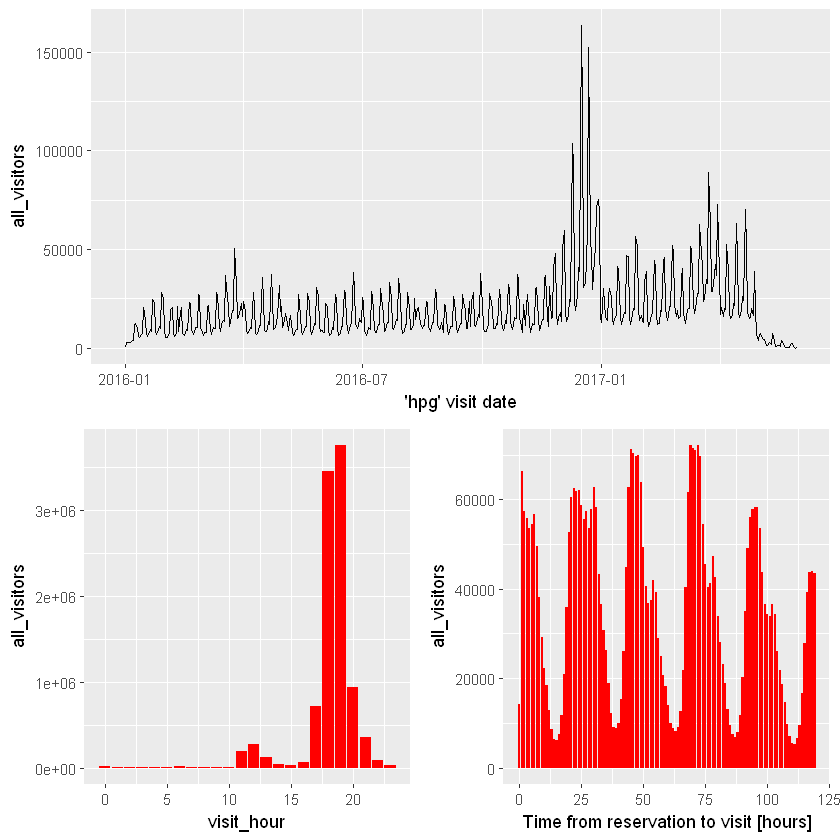

In [18]:
foo <- hpg_reserve %>%
  mutate(reserve_date = date(reserve_datetime),
         reserve_hour = hour(reserve_datetime),
         visit_date = date(visit_datetime),
         visit_hour = hour(visit_datetime),
         diff_hour = time_length(visit_datetime - reserve_datetime, unit = "hour"),
         diff_day = time_length(visit_datetime - reserve_datetime, unit = "day"))

p1 <- foo %>%
  group_by(visit_date) %>%
  summarise(all_visitors = sum(reserve_visitors)) %>%
  ggplot(aes(visit_date, all_visitors)) +
  geom_line() +
  labs(x = "'hpg' visit date")

p2 <- foo %>%
  group_by(visit_hour) %>%
  summarise(all_visitors = sum(reserve_visitors)) %>%
  ggplot(aes(visit_hour, all_visitors)) +
  geom_col(fill = "red")

p3 <- foo %>%
  filter(diff_hour < 24*5) %>%
  group_by(diff_hour) %>%
  summarise(all_visitors = sum(reserve_visitors)) %>%
  ggplot(aes(diff_hour, all_visitors)) +
  geom_col(fill = "red") +
  labs(x = "Time from reservation to visit [hours]")

layout <- matrix(c(1,1,2,3),2,2,byrow=TRUE)
multiplot(p1, p2, p3, layout=layout)

We find:

- Here the visits after reservation follow a more orderly pattern, with a clear spike in Dec 2016. As above for the *air* data, we also see reservation visits dropping off as we get closer to the end of the time frame.

- Again, most reservations are for dinner, and we see another nice 24-hour pattern for making these reservations. It's worth noting that here the last few hours before the visit don't see more volume than the 24 or 48 hours before. This is in stark constrast to the *air* data.


## Air Store

After visualising the temporal aspects, let's now look at the spatial information. Note, that according to the [data description](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data) the "latitude and longitude are the latitude and longitude of the area to which the store belongs". This is meant to discourage us from identifying specific restaurants. I would be surprised if nobody tried anyway, though.

This is a fully interactive and zoomable map of all the *air* restaurants. Click on the clusters to break them up into smaller clusters and ultimately into the individual restaurants, which are labelled by their *genre*. The map nicely visualises the fact that many restaurants share common coordinates, since those coordinates refer to the area of the restaurant. Click on the single markers to see their *air\_store\_id*. The map is powered by the [leaflet](https://rstudio.github.io/leaflet/) package, which includes a variety of cool tools for interactive maps. Have fun exploring!

In [19]:
leaflet(air_store) %>%
  addTiles() %>%
  addProviderTiles("CartoDB.Positron") %>%
  addMarkers(~longitude, ~latitude,
             popup = ~air_store_id, label = ~air_genre_name,
             clusterOptions = markerClusterOptions())

Warning message in readChar(htmlfile, file.info(htmlfile)$size):
"在non-UTF-8 MBCS语言环境里只能读取字节"

HTML widgets cannot be represented in plain text (need html)

Next, we plot the numbers of different types of cuisine (or *air\_genre\_names*) alongside the areas with the most *air* restaurants:

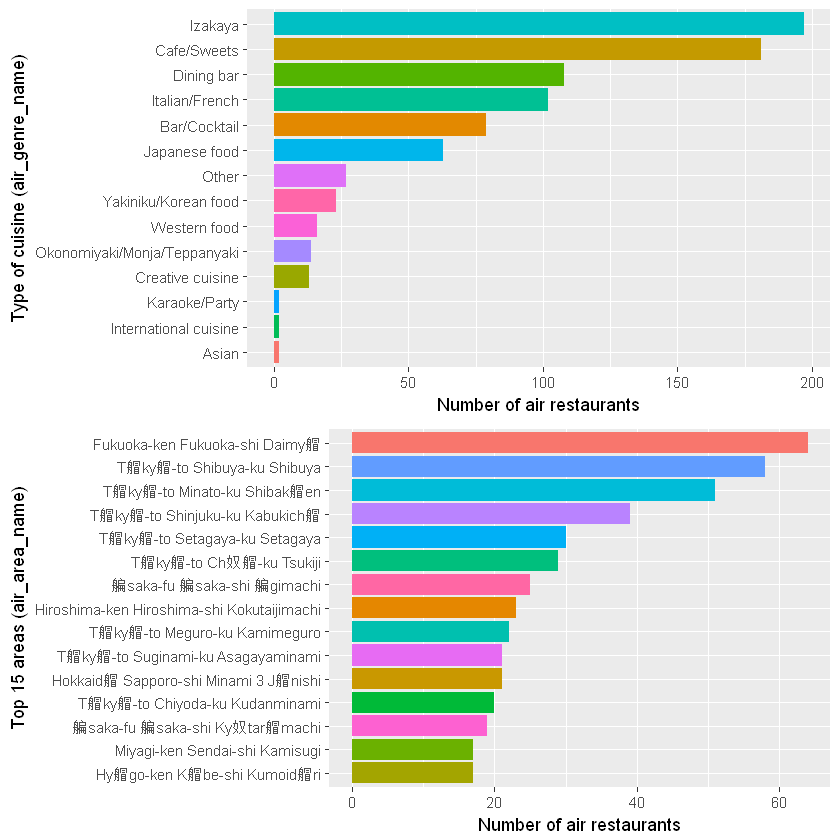

In [20]:
p1 <- air_store %>%
  group_by(air_genre_name) %>%
  count() %>%
  ggplot(aes(reorder(air_genre_name, n, FUN = min), n, fill = air_genre_name)) +
  geom_col() +
  coord_flip() +
  theme(legend.position = "none") +
  labs(x = "Type of cuisine (air_genre_name)", y = "Number of air restaurants")
  
p2 <- air_store %>%
  group_by(air_area_name) %>%
  count() %>%
  ungroup() %>%
  top_n(15,n) %>%
  ggplot(aes(reorder(air_area_name, n, FUN = min) ,n, fill = air_area_name)) +
  geom_col() +
  theme(legend.position = "none") +
  coord_flip() +
  labs(x = "Top 15 areas (air_area_name)", y = "Number of air restaurants")

layout <- matrix(c(1,2),2,1,byrow=TRUE)
multiplot(p1, p2, layout=layout)


We find:

- There are lots of [Izakaya](https://en.wikipedia.org/wiki/Izakaya) gastropubs in our data, followed by Cafe's. We don't have many Karaoke places in the *air* data set and also only a few that describe themselves as generically "International" or "Asian". I have to admit, I'm kind of intrigued by "creative cuisine".

- Fukuoka has the largest number of *air* restaurants per area, followed by many Tokyo areas.


## HPG Store

In the same way as for the *air* stores above, we also create an interactive map for the different *hpg* restaurants:


In [21]:
leaflet(hpg_store) %>%
  addTiles() %>%
  addProviderTiles("CartoDB.Positron") %>%
  addMarkers(~longitude, ~latitude,
             popup = ~hpg_store_id, label = ~hpg_genre_name,
              clusterOptions = markerClusterOptions())

Warning message in readChar(htmlfile, file.info(htmlfile)$size):
"在non-UTF-8 MBCS语言环境里只能读取字节"

HTML widgets cannot be represented in plain text (need html)

Here is the breakdown of *genre* and *area* for the *hpg* restaurants:

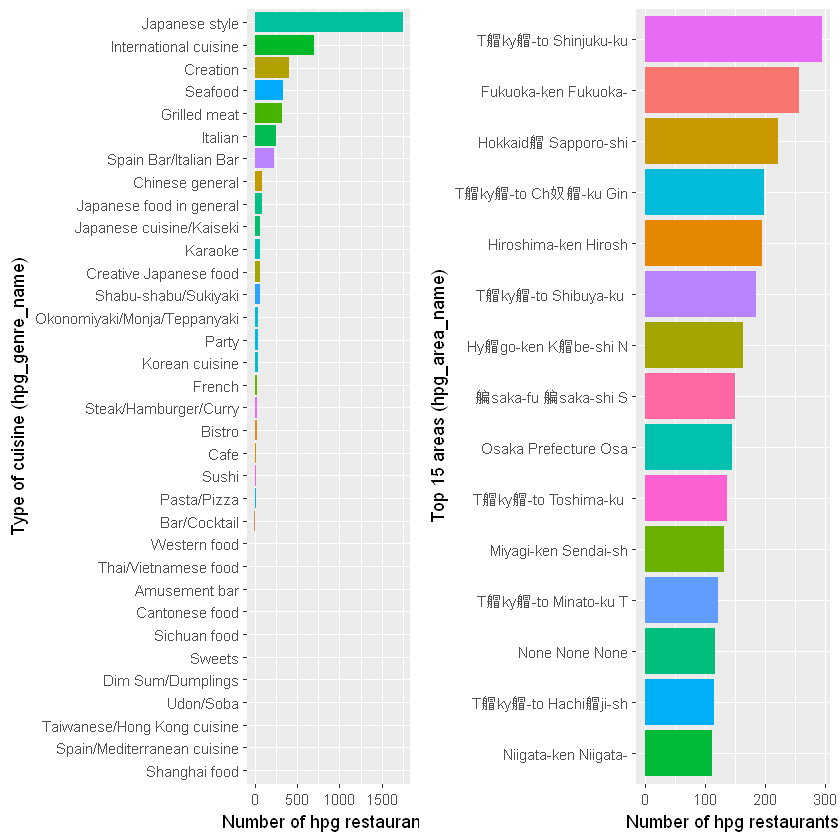

In [22]:
p1 <- hpg_store %>%
  group_by(hpg_genre_name) %>%
  count() %>%
  ggplot(aes(reorder(hpg_genre_name, n, FUN = min), n, fill = hpg_genre_name)) +
  geom_col() +
  coord_flip() +
  theme(legend.position = "none") +
  labs(x = "Type of cuisine (hpg_genre_name)", y = "Number of hpg restaurants")
  
p2 <- hpg_store %>%
  mutate(area = str_sub(hpg_area_name, 1, 20)) %>%
  group_by(area) %>%
  count() %>%
  ungroup() %>%
  top_n(15,n) %>%
  ggplot(aes(reorder(area, n, FUN = min) ,n, fill = area)) +
  geom_col() +
  theme(legend.position = "none") +
  coord_flip() +
  labs(x = "Top 15 areas (hpg_area_name)", y = "Number of hpg restaurants")

layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(p1, p2, layout=layout)

Here we have truncated the *hpg\_area\_name* to 20 characters to make the plot more readable.

We find:

- The *hpg* description contains a larger variety of *genres* than in the *air* data. Here, "Japanese style" appears to contain many more places that are categorised more specifically in the *air* data. The same applies to "International cuisine".

- In the top 15 area we find again Tokyo and Osaka to be prominently present.


## Holidays

Let's have a quick look at the holidays. We'll plot how many there are in total and also how they are distributed during our prediction time range in 2017 and the corresponding time in 2016:


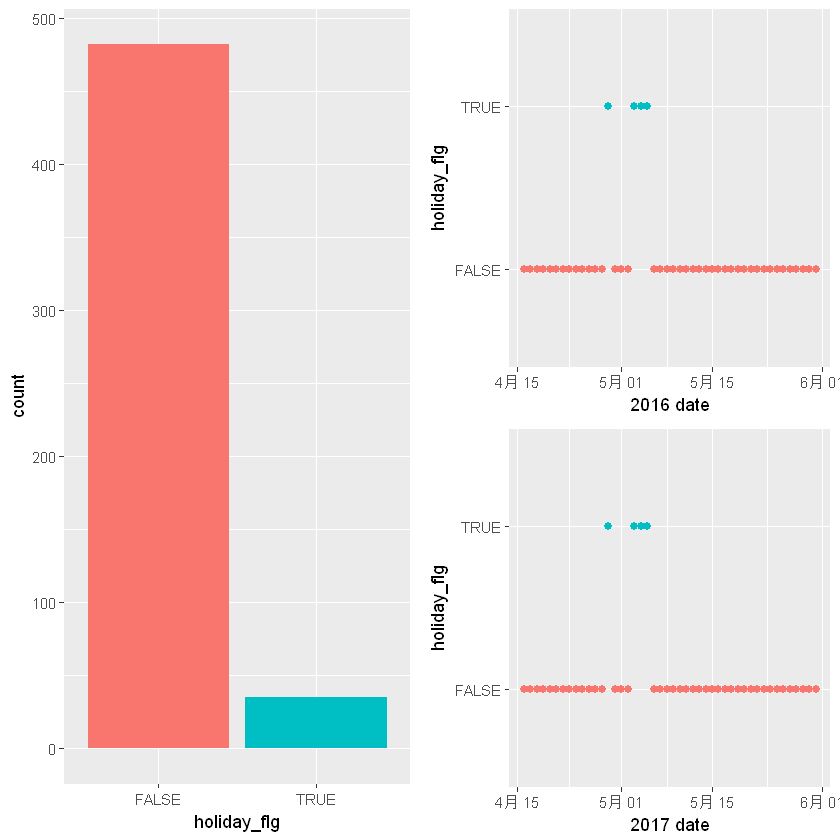

In [23]:
foo <- holidays %>%
  mutate(wday = wday(date))

p1 <- foo %>%
  ggplot(aes(holiday_flg, fill = holiday_flg)) +
  geom_bar() +
  theme(legend.position = "none")
  
p2 <- foo %>%
  filter(date > ymd("2016-04-15") & date < ymd("2016-06-01")) %>%
  ggplot(aes(date, holiday_flg, color = holiday_flg)) +
  geom_point(size = 2) +
  theme(legend.position = "none") +
  labs(x = "2016 date")

p3 <- foo %>%
  filter(date > ymd("2017-04-15") & date < ymd("2017-06-01")) %>%
  ggplot(aes(date, holiday_flg, color = holiday_flg)) +
  geom_point(size = 2) +
  theme(legend.position = "none") +
  labs(x = "2017 date")

layout <- matrix(c(1,1,2,3),2,2,byrow=FALSE)
multiplot(p1, p2, p3, layout=layout)

We find:

- The same days were holidays in late Apr / May in 2016 as in 2017.

- There are about 7% holidays in our data:

```{r}
holidays %>% group_by(holiday_flg) %>% count() %>% spread(holiday_flg,n) %>% mutate(frac = `TRUE`/(`TRUE`+`FALSE`))
```


## Test data set

The following plot visualises the time range of the *train* vs *test* data sets:

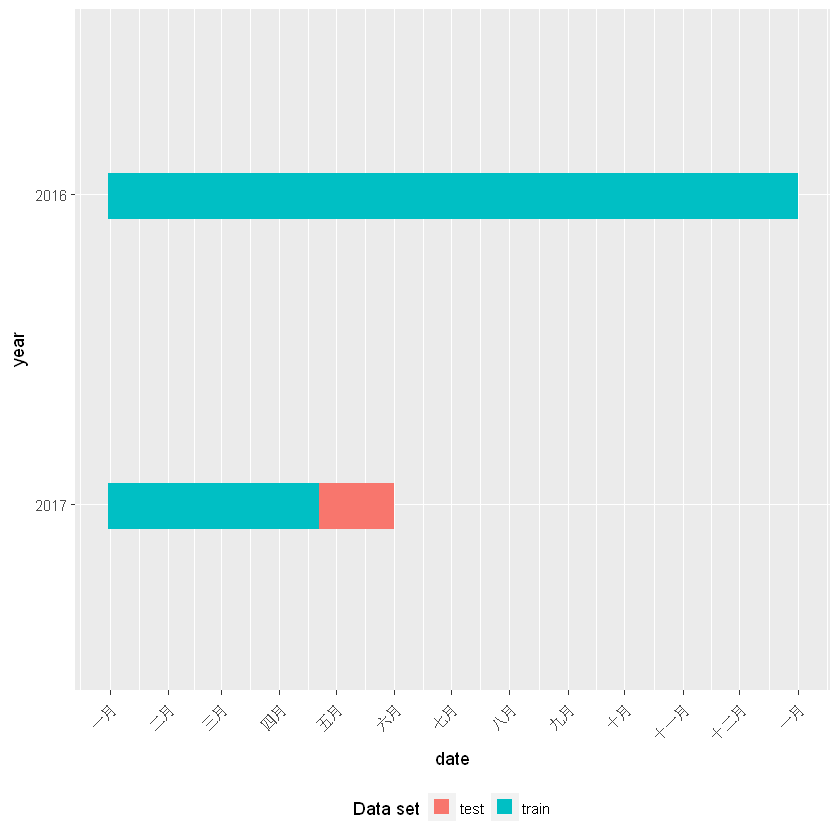

In [35]:
foo <- air_visits %>%
  rename(date = visit_date) %>%
  distinct(visit_date) %>%
  mutate(dset = "train")
bar <- test %>%
  separate(id, c("foo", "bar", "date"), sep = "_") %>%
  mutate(date = ymd(date)) %>%
  distinct(date) %>%
  mutate(dset = "test")
foo <- foo %>%
  bind_rows(bar) %>%
  mutate(year = year(date))
  year(foo$date) <- 2017

foo %>%
  filter(!is.na(date)) %>%
  mutate(year = fct_relevel(as.factor(year), c("2017","2016"))) %>%
  ggplot(aes(date, year, color = dset)) +
  geom_point(shape = "|", size = 10) +
  scale_x_date(date_labels = "%B", date_breaks = "1 month") +
  #scale_y_reverse() +
  theme(legend.position = "bottom", axis.text.x  = element_text(angle=45, hjust=1, vjust=0.9)) +
  labs(color = "Data set") +
  guides(color = guide_legend(override.aes = list(size = 4, pch = 15)))




# Feature relations

After looking at every data set individually, let's get to the real fun and start combining them. This will tell us something about the relations between the various features and how these relationsy might affect the visitor numbers. Any signal we find will need to be interpreted in the context of the individual feature distributions; which is why it was one of our first steps to study those.


## Visitors per genre

Our first plot of the multi-feature space deals with the average number of *air* restaurant *visitors* broken down by type of cuisine; i.e. the *air\_genre\_name*. We use a facet plot to distinguish the time series for the 14 categories. Note the logarithmic y-axis:

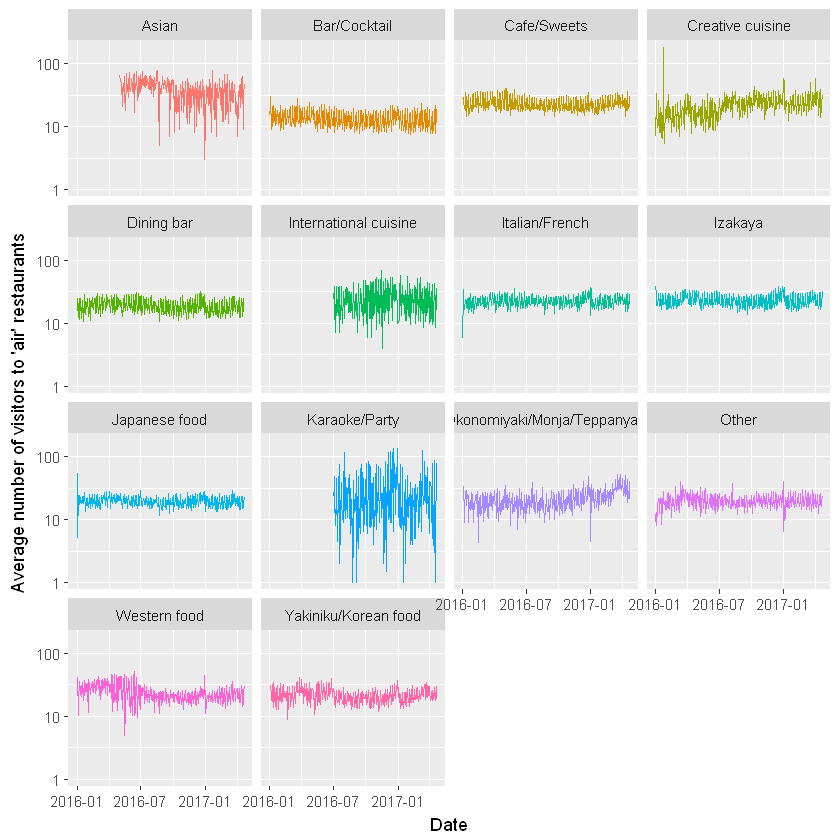

In [36]:
foo <- air_visits %>%
  left_join(air_store, by = "air_store_id")

foo %>%
  group_by(visit_date, air_genre_name) %>%
  summarise(mean_visitors = mean(visitors)) %>%
  ungroup() %>%
  ggplot(aes(visit_date, mean_visitors, color = air_genre_name)) +
  geom_line() +
  labs(y = "Average number of visitors to 'air' restaurants", x = "Date") +
  theme(legend.position = "none") +
  scale_y_log10() +
  facet_wrap(~ air_genre_name)

We find:

- The mean values range between 10 and 100 visitors per genre per day. Within each category, the long-term trend looks reasonably stable. There is an upward trend for "Creative Cuisine" and "Okonomiyaki" et al., while the popularity of "Asian" food has been declining since late 2016. 

- The low-count time series like "Karaoke" or "Asian" (see Fig. 6) are understandably more noisy than the genres with higher numbers of visitors. Still, "Asian" restaurants appear to be very popular despite (or because of?) their rarity.


In all of the curves we see the familiar weekly variation, so let's look in more detail at the mean visitor numbers per week day and genre. We also add to this a series of *ridgeline plots* via the [ggridges](https://cran.r-project.org/web/packages/ggridges/) package. Ridgeline plots allow for a quick comparison of semi-overlapping (density) curves. Here we show the distribution of visitors per day for each *genre*. Through a little bit of ggplot magic, the y-axis labels in between those two plots refer to both of them:

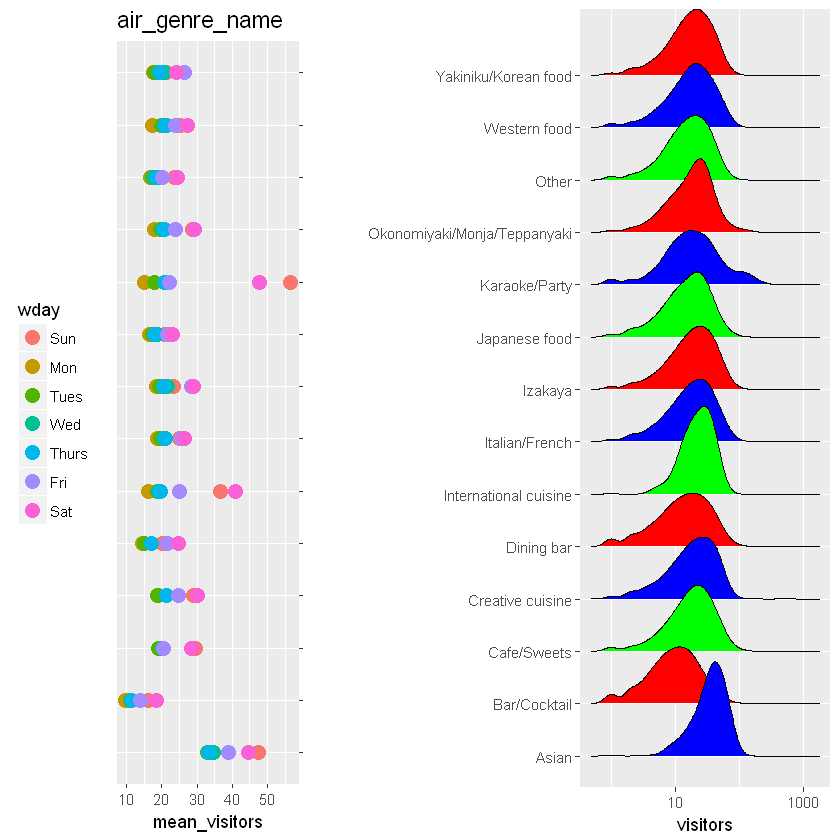

In [57]:
p1 <- foo %>%
  mutate(wday = wday(visit_date, label = TRUE)) %>%
  group_by(wday, air_genre_name) %>%
  summarise(mean_visitors = mean(visitors)) %>%
  ggplot(aes(air_genre_name, mean_visitors, color = wday)) +
  geom_point(size = 4) +
  theme(legend.position = "left", axis.text.y = element_blank(),
        plot.title = element_text(size = 14)) +
  coord_flip() +
  labs(x = "") +
  scale_x_discrete(position = "top") +
  ggtitle("air_genre_name") +
  scale_color_hue()

p2 <- foo %>%
  ggplot(aes(visitors, air_genre_name, fill = air_genre_name)) +
  geom_density_ridges(bandwidth = 0.1) +
  scale_x_log10() +
  theme(legend.position = "none") +
  labs(y = "") +
  scale_fill_cyclical(values = c("blue", "red","green"))

layout <- matrix(c(1,1,2,2,2),1,5,byrow=TRUE)
multiplot(p1, p2, layout=layout) 
p1 <- 1; p2 <- 1; p3 <- 1; p4 <- 1; p5 <- 1

Here each colour corresponds to a day of the week. Red-ish coulours are the weekend, while the cooler colours are the middle of the week. Monday is dark orange.

We find:

- The biggest difference between weekend and weekdays exists for the "Karaoke" bars, which rule the weekend. A similar trend, although with a considerably smaller gap, can be seen for the "International" cuisine.

- No *genre* really goes against the trend of busier weekends. The smallest variations are in the generic "Other" category, the "Japanese" food, and also the "Korean" cuisine which is the only category where Fridays are the busiest days. General "Bars/Cocktail" are notably unpopular overall.

- The density curves confirm the impression we got from the week-day distribution: the "Asian" restaurants have rarely less than 10 visitors per date and the "Karaoke" places show a very broad distribution due to the strong impact of the weekends. Note the logarithmic x-axis.


## The impact of holidays

We will study the influence of holidays on our visitor numbers by comparing the statistics for days with holidays vs those without holiday flag:


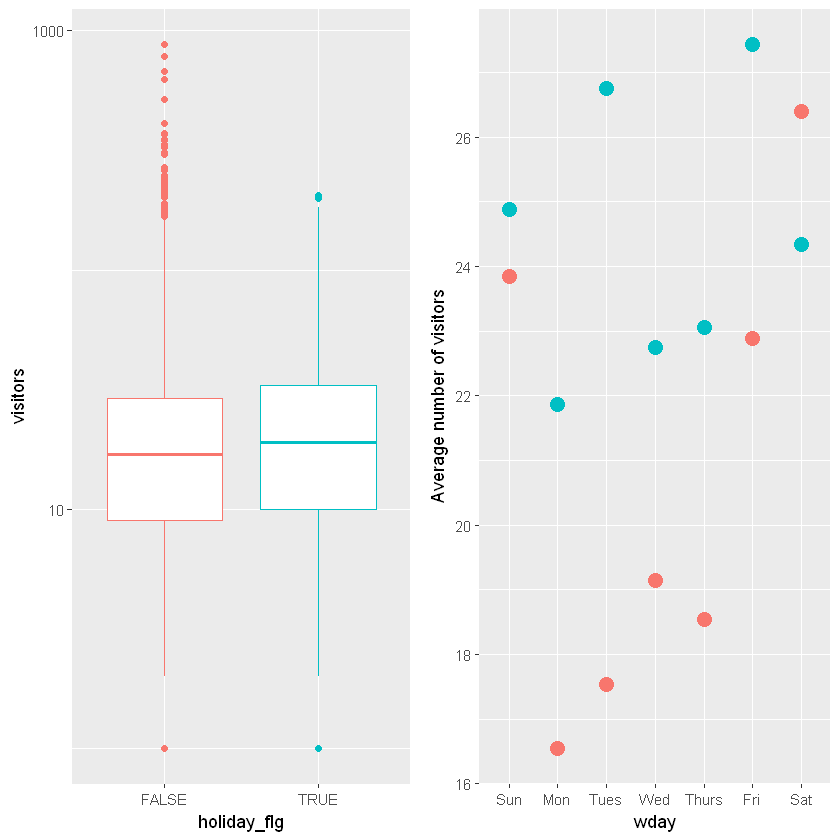

In [59]:
foo <- air_visits %>%
  mutate(calendar_date = as.character(visit_date)) %>%
  left_join(holidays, by = "calendar_date")

p1 <- foo %>%
  ggplot(aes(holiday_flg, visitors, color = holiday_flg)) +
  geom_boxplot() +
  scale_y_log10() +
  theme(legend.position = "none")

p2 <- foo %>%
  mutate(wday = wday(date, label = TRUE)) %>%
  group_by(wday, holiday_flg) %>%
  summarise(mean_visitors = mean(visitors)) %>%
  ggplot(aes(wday, mean_visitors, color = holiday_flg)) +
  geom_point(size = 4) +
  theme(legend.position = "none") +
  labs(y = "Average number of visitors")

layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(p1, p2, layout=layout)


We find:

- Overall, holidays don't have any impact on the average visitor numbers (left panel). As so often, more information is hidden in the details.

- While a weekend holiday has little impact on the visitor numbers, and even decreases them slightly, there is a much more pronounced effect for the weekdays; especially Monday and Tuesday (right panel).


## Restaurants per area and the effect on visitor numbers

Our next exploration follows from a simple thought: if gastropubs are popular and we own the only gastropub in the area then we can expect lots of customers. If there are twelve other gastropubs in our street then, try as we might, some of those customers will venture into other establishments. Economists tell us that we can ultimately expect a convergence towards an equilibrium between supply and demand. But for snapshots like our data set, and for relatively localised areas, there might still be merit in investigating restaurant clustering. Therefore, let's study the number of restaurants of a certain *genre* per *area* and their impact on visitor numbers.

We begin with an overview plot of the frequency of certain genres per area for the two data sets of *air* and *hpg* stores. This could have well been a part of the previous chapter, but I only just thought about it ;-) . The following *count plots* show which *genres* exist in which *areas* (names truncated). The size of the dots is proportional to the number of cases:

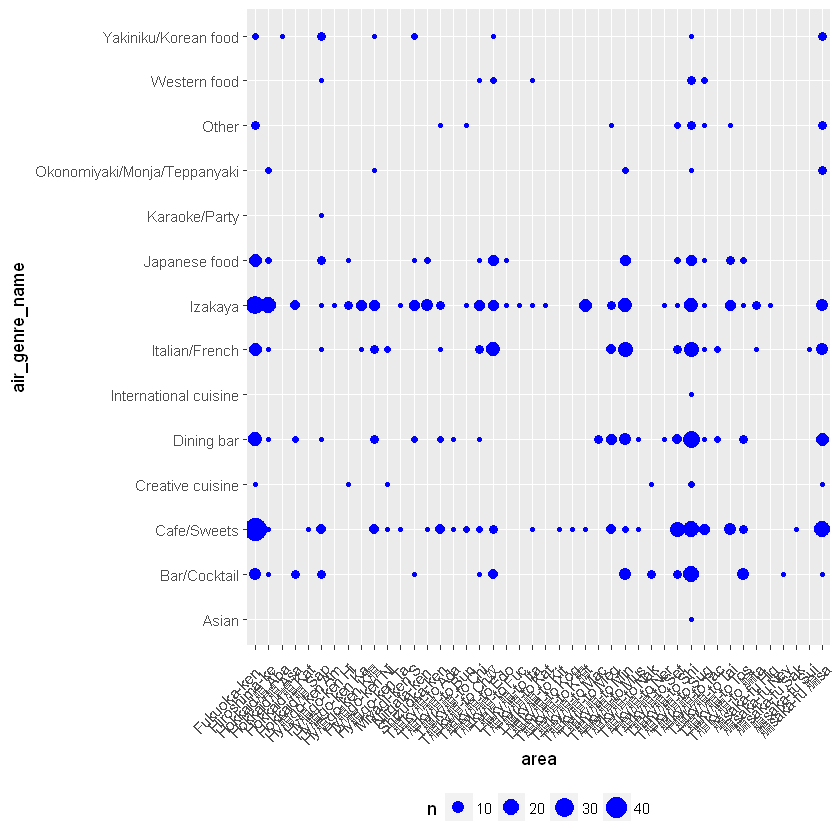

In [60]:
air_store %>%
  mutate(area = str_sub(air_area_name, 1, 12)) %>%
  ggplot(aes(area, air_genre_name)) +
  geom_count(colour = "blue") +
  theme(legend.position = "bottom", axis.text.x  = element_text(angle=45, hjust=1, vjust=0.9))


We find:

- Some *areas* have lots of restaurants and much variety, whereas others contain only a single *air* restaurant. Large parts of the parameter space are empty.

- Similarly, some cuisines like "Izakaya" or "Cafe" are pretty ubiqutous, whereas others can only be found in a few areas. Note, that the only 2 Karaoke bars in the *air* sample are in "Hokkaido Sapporo-shi Minami 3 Jonishi", whereas the only 2 "International cuisine" restaurants as well as the only two "Asian" places can be found in "Tokyo-to Shibuya-ku Shibuya".


The same kind of plot for the *hpg* data looks similar albeit more busy due to the larger number of *genres*:

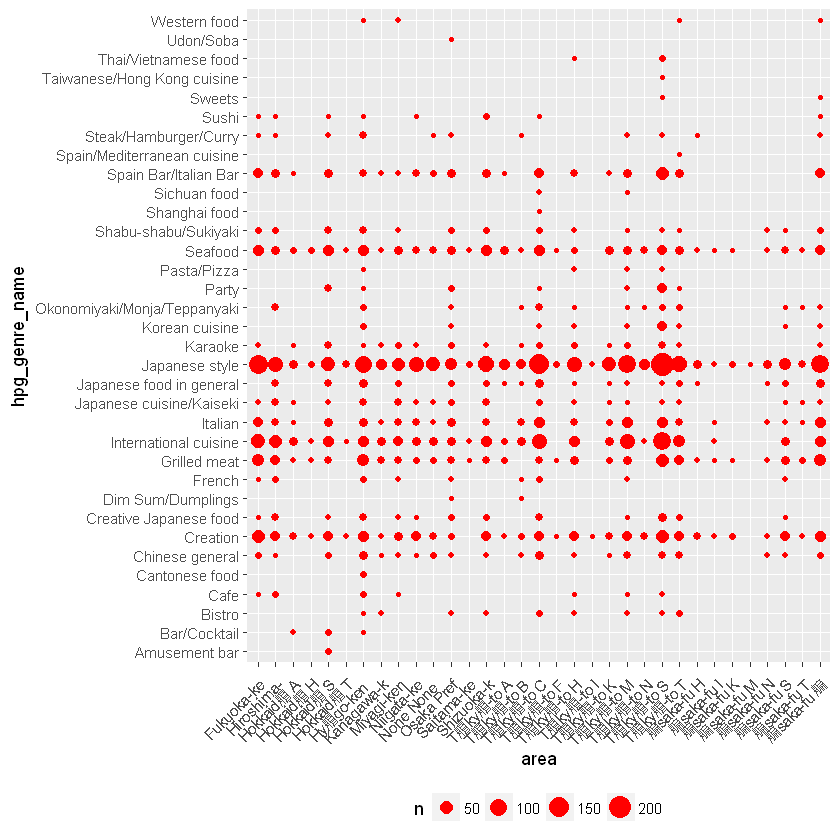

In [61]:
hpg_store %>%
  mutate(area = str_sub(hpg_area_name, 1, 10)) %>%
  ggplot(aes(area, hpg_genre_name)) +
  geom_count(colour = "red") +
  theme(legend.position = "bottom", axis.text.x  = element_text(angle=45, hjust=1, vjust=0.9))

We find:

- Also here there are busy areas and those with only a few restaurants. Unsurprisingly, Tokyo features prominently in the areas with a lot of culinary diversity.

- "Japanese style" and "International cuisine" are popular pretty much everywhere. "Amusement bars" and "Udon/Soba" places are rare, as are "Shanghai food" or "Dim Sum".


The count plots tell us that there is a distribution of how many restaurants of a certain *genre* can be found per *area*. Here we look at these distributions in detail via boxplots with overlayed jitter plots. The *genres* are ordered by decreasing mean cases per area, i.e. the mean of a horizontal sequence of dots in a count plot. The we overlay the indvidual data point and assign each dot a random jitter to visually separate otherwise overlapping data. Here, the y axis (i.e. "Occurences per area") correspond to the size of the dots in the count plots above. We're using single plots here, instead of panels, because these plots are quite detailed. Note the logarithmic y-axes.

We start with the *air* data:

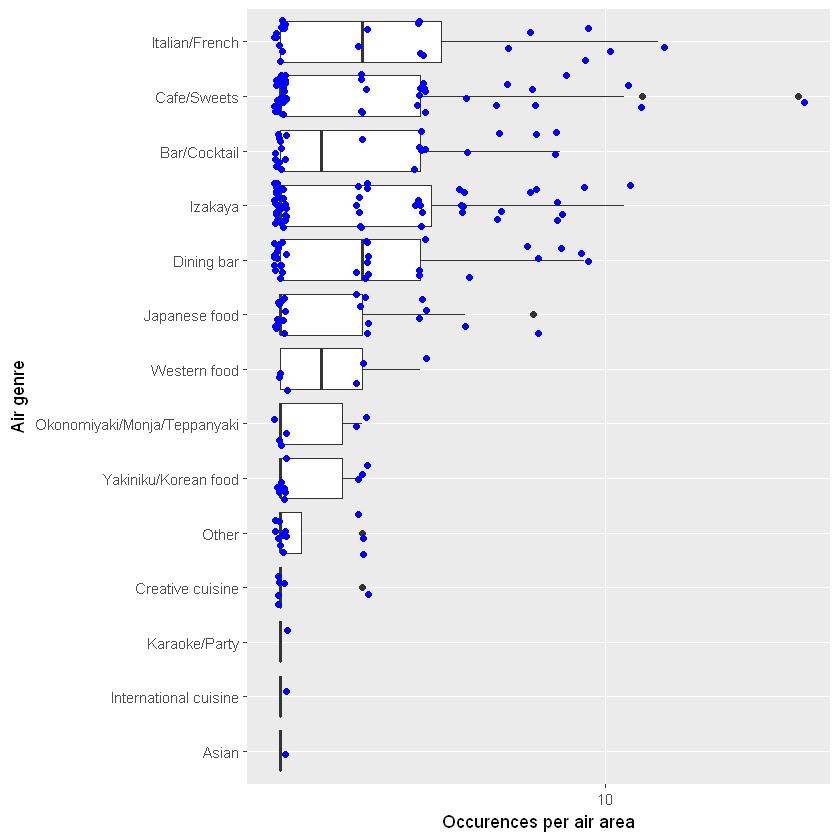

In [64]:
air_store %>%
  group_by(air_genre_name, air_area_name) %>%
  count() %>%
  ggplot(aes(reorder(air_genre_name, n, FUN = mean), n)) +
  geom_boxplot() +
  geom_jitter(color = "blue") +
  scale_y_log10() +
  coord_flip() +
  labs(x = "Air genre", y = "Occurences per air area")

We find:

- Only few *genres* have medians of more than 2 restaurants per area. Examples are "Italian/French" restaurants or "Bar/Cocktail" places, which are more likely to be found in groups of more than 2 per area.

- For the majority of *genres* the distribution is firmly clustered around 2 cases per area with a bit of scatter towards higher numbers. "Cafes" have the highest number with 26 occurences in a single area (Fukuoka-ken Fukuoka-shi DaimyÅ).

- Curiously, the minimum here is 2, not 1. This means that there is no *air* restaurant that is the only one of it's *genre* in any *area*. You can see that also on the map in Fig. 5: whenever there is a group of 2 restaurants at the same *area* coordinates they have the same *genre* (but different *air\_store\_ids*). Similarly, there are no single occurrences of a *genre* in any larger group per area. (There exist odd numbers of occurences though, i.e. 3 or 5 of the same *genre* per *area*.) I'm not quite sure what to make of that, since it seems too perfectly matched to be true. Could it have something to do with the way the *air* data have been selected? Might it be a bug in assigning *genre* names? I checked a few examples of 2 restaurants in one spot and they have different visitor numbers on the same day, e.g. for this pair of "Dining Bars", indicating that we don't simply have a problem of single entries being duplicated here:


In [66]:
air_store %>%
  filter(air_store_id == "air_b5598d12d1b84890" | air_store_id == "air_bbe1c1a47e09f161")

air_visits %>%
  filter(air_store_id == "air_b5598d12d1b84890" | air_store_id == "air_bbe1c1a47e09f161") %>%
  arrange(visit_date) %>%
  head(10)

air_store_id,air_genre_name,air_area_name,latitude,longitude
air_bbe1c1a47e09f161,Dining bar,T艒ky艒-to Setagaya-ku Kitazawa,35.66266,139.6683
air_b5598d12d1b84890,Dining bar,T艒ky艒-to Setagaya-ku Kitazawa,35.66266,139.6683


air_store_id,visit_date,visitors
air_bbe1c1a47e09f161,2016-07-01,7
air_b5598d12d1b84890,2016-07-01,5
air_b5598d12d1b84890,2016-07-02,14
air_b5598d12d1b84890,2016-07-03,6
air_b5598d12d1b84890,2016-07-04,6
air_b5598d12d1b84890,2016-07-05,5
air_b5598d12d1b84890,2016-07-06,5
air_bbe1c1a47e09f161,2016-07-07,1
air_bbe1c1a47e09f161,2016-07-08,7
air_b5598d12d1b84890,2016-07-08,10


Now we look at the same distribution for the HPG restaurants:

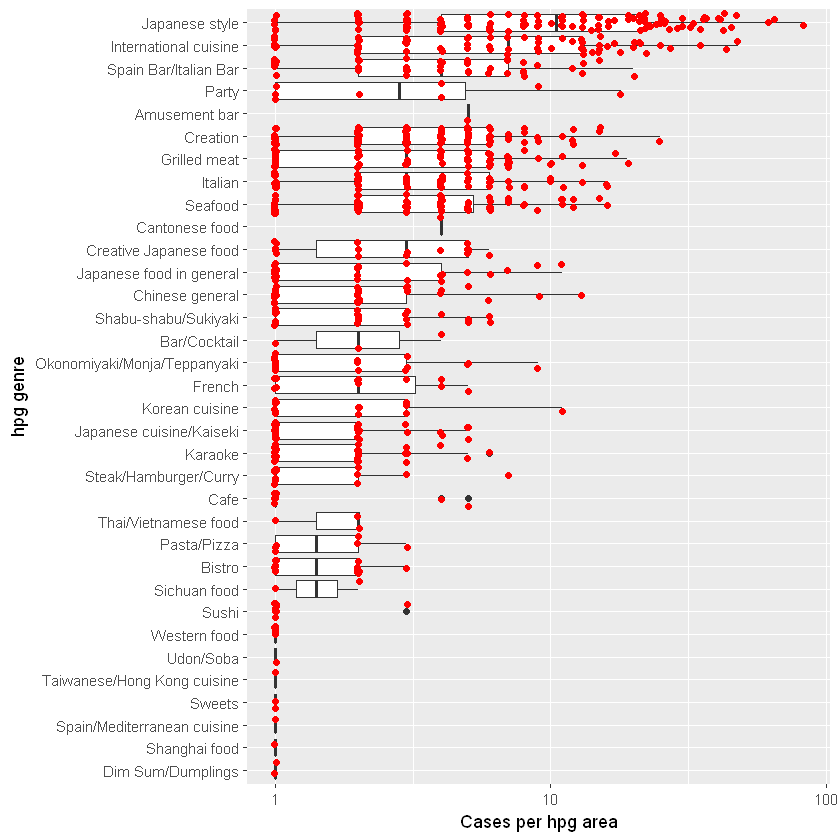

In [67]:
foobar <- hpg_store %>%
  group_by(hpg_genre_name, hpg_area_name) %>%
  count()

foobar %>%
  ggplot(aes(reorder(hpg_genre_name, n, FUN = mean), n)) +
  geom_boxplot() +
  geom_jitter(color = "red") +
  scale_y_log10() +
  coord_flip() +
  labs(x = "hpg genre", y = "Cases per hpg area")

We find:

- Here we clearly have a minimum of 1 *genre* per *area*, and also much more variety in median cases due to the higher overall numbers.

- The most extreme *genre* is "Japanese style" for which the median is just above 10 restaurants per area. Alongside of this, there a number of other *genres* for which the lower box hinge is not touching the minimum of 1 case per *area*.


Using the information on the number of *genres* in each area we can now proceed to quantify the clustering, or "crowdedness", of our data set and relate it to the *visitor* numbers. The next plot first shows the overall distribution of the *air* and *hpg* data points from the last two plots (i.e. cases of the same *genre* per *area*).

In addition, we estimate the mean visitor numbers for each clustering case. For this, we first take the mean of the `log1p`-transformed visitor numbers (per *genre* and *area*) and then compute the mean and standard deviation of these numbers for each case, i.e. number of occurences of the same *genre* in an *area*. (`log1p` means `log(x+1)` and is intended to make the *visitors* number distribution more normal; see Fig. 1).

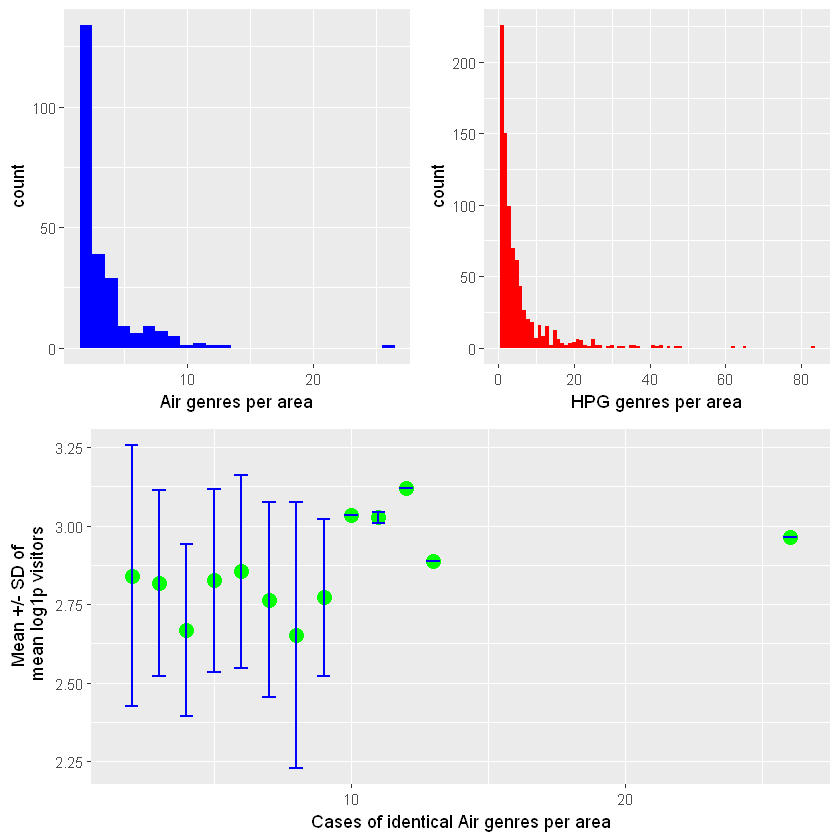

In [69]:
foo <- air_visits %>%
  left_join(air_store, by = "air_store_id")

bar <- air_store %>%
  group_by(air_genre_name, air_area_name) %>%
  count()

foobar <- hpg_store %>%
  group_by(hpg_genre_name, hpg_area_name) %>%
  count()

p1 <- bar %>%
  ggplot(aes(n)) +
  geom_histogram(fill = "blue", binwidth = 1) +
  labs(x = "Air genres per area")

p2 <- foobar %>%
  ggplot(aes(n)) +
  geom_histogram(fill = "red", binwidth = 1) +
  labs(x = "HPG genres per area")

p3 <- foo %>%
  group_by(air_genre_name, air_area_name) %>%
  summarise(mean_log_visit = mean(log1p(visitors))) %>%
  left_join(bar, by = c("air_genre_name","air_area_name")) %>%
  group_by(n) %>%
  summarise(mean_mlv = mean(mean_log_visit),
            sd_mlv = sd(mean_log_visit)) %>%
  replace_na(list(sd_mlv = 0)) %>%
  ggplot(aes(n, mean_mlv)) +
  geom_point(color = "green", size = 4) +
  geom_errorbar(aes(ymin = mean_mlv - sd_mlv, ymax = mean_mlv + sd_mlv), width = 0.5, size = 0.7, color = "blue") +
  labs(x = "Cases of identical Air genres per area", y = "Mean +/- SD of\n mean log1p visitors")

layout <- matrix(c(1,2,3,3),2,2,byrow=TRUE)
multiplot(p1, p2, p3, layout=layout)

We find:

- Upper panels: The numbers of cases of identical *genres* in the same *area* drops quickly, possibly exponentially, from the maxima of "2" and "1" for *air* and *hpg* data sets, respectively. There is a longer tail towards larger case numbers, with a possible 2nd peak around "8" for *air* and about "13" for *hpg*.

- Lower panel: The `log1p` means of *visitor* numbers show relatively large spread and are perfectly consistent in the range from "2" cases to "9". From 10 cases upward we simply don't have the numbers to measure a spread: there are two data points with 11 cases per *area* and otherwise it's just a single measurement. However, it is noteworthy that the scatter among all the data points > 9 cases is pretty low, and that the lie notably higher than the means of the points <= 9. Now, that could simply mean that those high visitor numbers are not being "brought down" by small (less busy?) areas, but that in itself is an interesting result.

- Note that the scatter plot in the lower panel mixes treats all the clustering/crowding cases regardless of *genre*. We can of course only draw this plot for the *air* data for which we have *visitor* numbers.

We will try another method of quantifying the 'distinctiveness' of a restaurant by the distance to its neighbouring restaurants in the feature engineering section.


## Reservations vs Visits

Next we will turn our attention to the *reservation* numbers in the `air_reserve` and `hpg_reserve` data sets. We have seen their time series and distributions back in Sections 4.2 and 4.3; now we will compare the reservation numbers to the actual visitor numbers.

For this, we compute the sum of *reserve\_visitors* per day (i.e. the number of people reservations were made for) for each restaurant *id* and then join these summaries to the *air\_visitors* file. In order to include the *hpg* reservations we need to use the *store\_ids* data to join the *hpg\_store\_ids* from the *hpg\_reserve* file to the corresponding *air\_store\_ids*:


In [71]:
foo <- air_reserve %>%
  mutate(visit_date = date(visit_datetime)) %>%
  group_by(air_store_id,visit_date) %>%
  summarise(reserve_visitors_air = sum(reserve_visitors))
  
bar <- hpg_reserve %>%
  mutate(visit_date = date(visit_datetime)) %>%
  group_by(hpg_store_id,visit_date) %>%
  summarise(reserve_visitors_hpg = sum(reserve_visitors)) %>%
  inner_join(store_ids, by = "hpg_store_id")

all_reserve <- air_visits %>%
  inner_join(foo, by = c("air_store_id", "visit_date")) %>%
  inner_join(bar, by = c("air_store_id", "visit_date")) %>%
  mutate(reserve_visitors = reserve_visitors_air + reserve_visitors_hpg)

Now we will plot the total *reserve\_visitor* numbers against the actual *visitor* numbers for the *air* restaurants. We use a scatter plot to which we are adding marginal histograms via the `ggMarginal` function of the `ggExtra` [package](https://cran.r-project.org/web/packages/ggExtra/). The grey line shows `reserve_visitors == visitors` and the blue line is a linear fit:

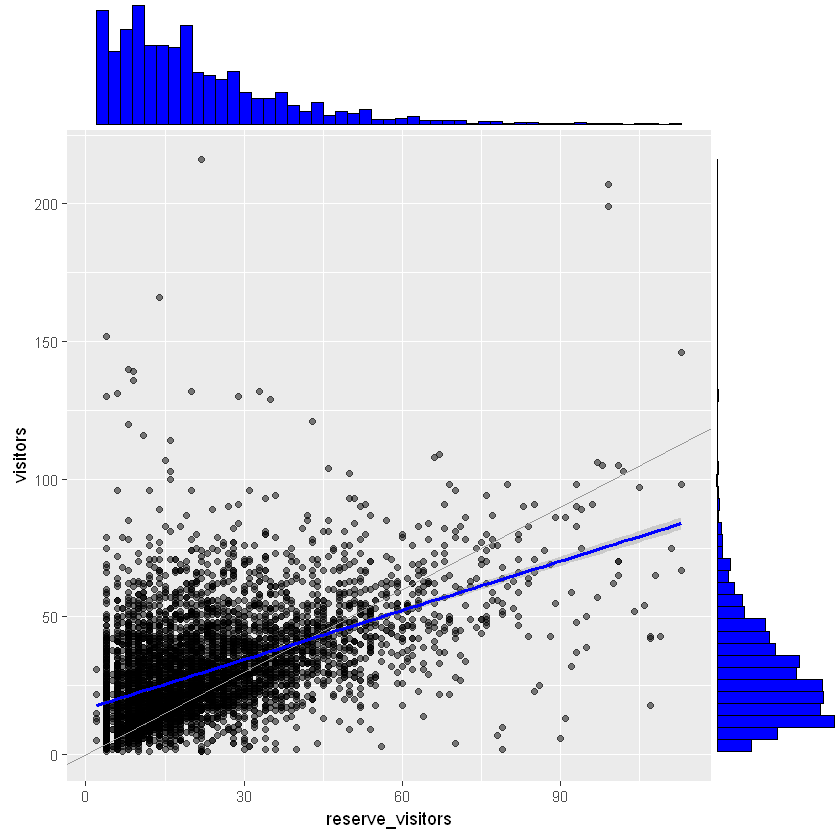

In [72]:
p <- all_reserve %>%
  filter(reserve_visitors < 120) %>%
  ggplot(aes(reserve_visitors, visitors)) +
  geom_point(color = "black", alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = "grey60") +
  geom_smooth(method = "lm", color = "blue")
ggMarginal(p, type="histogram", fill = "blue", bins=50)

We find:

- The histograms show that the *reserve\_visitors* and *visitors* numbers peak below ~20 and are largely confined to the range below 100.

- The scatter points fall largely above the line of identity, indicating that there were more *visitors* that day than had reserved a table. This is not surprising, since a certain number of people will always be walk-in customers.

- A notable fraction of the points is below the line, which probably indicates that some people made a reservation but changed their mind and didn't go. That kind of effect is probably to be expected and taking it into account will be one of the challenges in this competition.

- The linear fit suggests a trend in which larger numbers of *reserve\_visitors* are more likely to underestimate the eventual *visitor* numbers. This is not surprising either, since I can imagine that it is more likely that (a) a large reservation is cancelled than (b) a large group of people walk in a restaurant without reservation.


Now we will break down the discrepancy between `visitors - reserve_visitors` over time, look at the overall histograms, and visualise the *air\_reserve* vs *hpg\_reserve* numbers separately. Here, the time series for *air* (blue) and *hpg* (red) are offset vertically by 150 and -250 (see the solid black baselines):

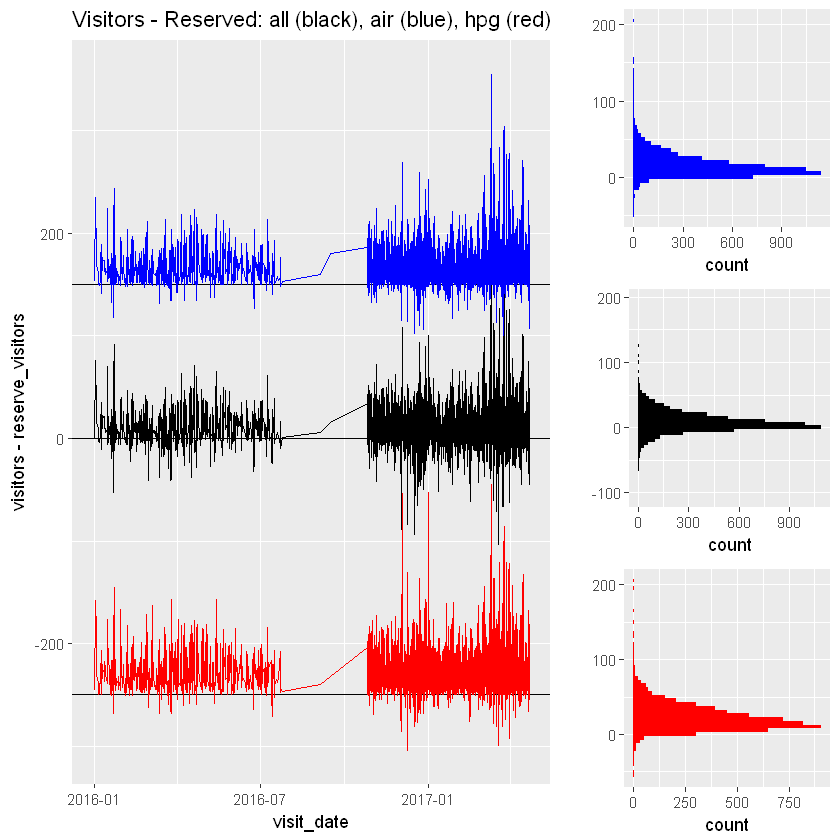

In [75]:
p1 <- all_reserve %>%
  ggplot(aes(visitors - reserve_visitors)) +
  geom_histogram(binwidth = 5, fill = "black") +
  coord_flip() +
  labs(x = "")

p2 <- all_reserve %>%
  ggplot(aes(visitors - reserve_visitors_air)) +
  geom_histogram(binwidth = 5, fill = "blue") +
  coord_flip() +
  labs(x = "")

p3 <- all_reserve %>%
  ggplot(aes(visitors - reserve_visitors_hpg)) +
  geom_histogram(binwidth = 5, fill = "red") +
  coord_flip() +
  labs(x = "")

p4 <- all_reserve %>%
  ggplot(aes(visit_date, visitors - reserve_visitors)) +
  geom_hline(yintercept = c(150, 0, -250)) +
  geom_line() +
  geom_line(aes(visit_date, visitors - reserve_visitors_air + 150), color = "blue") +
  geom_line(aes(visit_date, visitors - reserve_visitors_hpg - 250), color = "red") +
  ggtitle("Visitors - Reserved: all (black), air (blue), hpg (red)")

layout <- matrix(c(4,4,2,4,4,1,4,4,3),3,3,byrow=TRUE)
multiplot(p1, p2, p3, p4, layout=layout)

We find:

- The time series show significant scatter throughout the *training* time range. While the *air* (blue) and *hpg* (red) curves are predominantly above the baseline (i.e. more *visitors* than *reservations*), combining the two data sets brings the mean of the distribution closer to the zero line. This can also be seen in the corresponding histograms on the right side.

- We see the gap where there are no *air* reservations (compare Sect. 4.2). We could only look at the *hpg* reservations here (for which this gap does not exist, Sect. 4.3) but it appears safe to assume that they would follow the same trend and can be used as a proxy for the *air* reservations. Feel free to check this assumption for the gap.

- The (flipped) histograms in the 3 right panels are roughly aligned with the time series in the left panel for convenience of interpretation. They demonstrate how much the distributions are skewed towards larger *visitor* numbers than *reserve\_visitor* numbers. We might see a mix here between two distributions: a (probably normal) spread due to cancellations plus a tail from walk-in visitors, which should follow a Poisson distribution.


Finally, let's have a quick look at the impact of holidays on the discrepancy between *reservations* and *visitors*. We'll be using overlapping density plots:

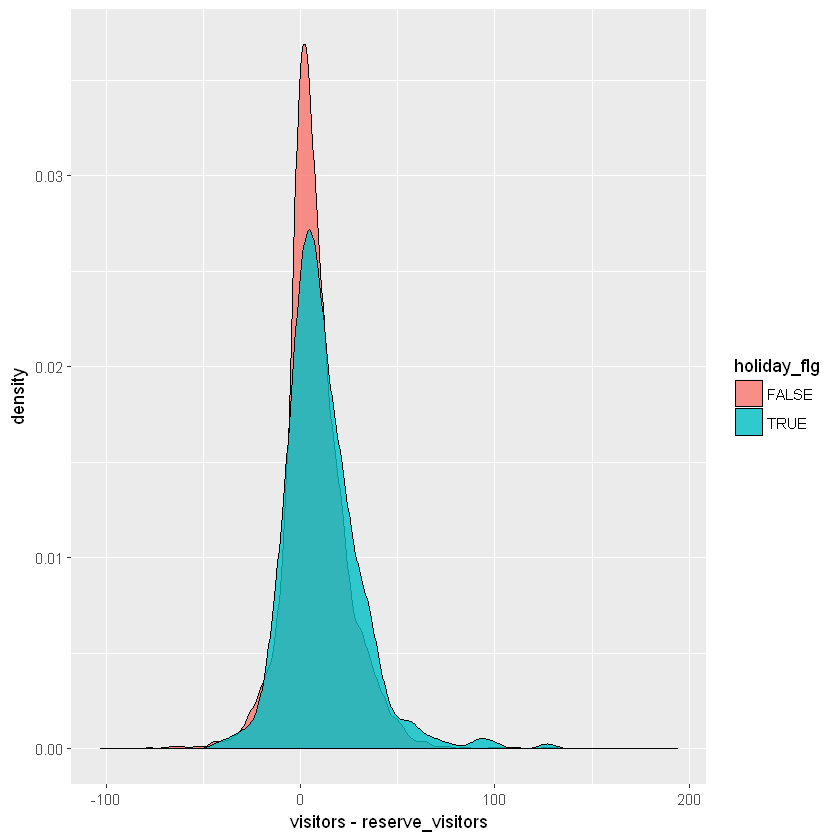

In [78]:
all_reserve %>%
  mutate(date = visit_date) %>%
  left_join(holidays, by = "date") %>%
  ggplot(aes(visitors - reserve_visitors, fill = holiday_flg)) +
  geom_density(alpha = 0.8)

We find:

- There are somewhat higher numbers of *visitors* compared to *reservations* on a holiday. The peaks are almost identical, but we see small yet clear differences towards larger numbers.


# Feature engineering

The next step is to derive new features from the existing ones and the purpose of these new features is to provide additional predictive power for our goal to forecast *visitor* numbers. Those new features can be as simple as deriving the *day of the week* or the *month* from a *date* column; something that we have already used in Fig. 1 of our visual exploration. Or they can take a more complex shape from the interplay of several related variables. This section collects and studies these new features.

My personal preference is to collect all engineered features into a single code block, so that we don't have to search for them in different places of the kernel. Often, this also makes the computation of these features easier as we can re-use certain intermediate transformations. As we expand our analysis, we will come back to this code block and it will grow as our feature space grows:

In [81]:
air_visits <- air_visits %>%
  mutate(wday = wday(visit_date, label=TRUE),
         wday = fct_relevel(wday,c("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")),
         month = month(visit_date, label=TRUE))

air_reserve <- air_reserve %>%
  mutate(reserve_date = date(reserve_datetime),
         reserve_hour = hour(reserve_datetime),
         reserve_wday = wday(reserve_datetime, label = TRUE),
         reserve_wday = fct_relevel(reserve_wday, c("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")),
         visit_date = date(visit_datetime),
         visit_hour = hour(visit_datetime),
         visit_wday = wday(visit_datetime, label = TRUE),
         visit_wday = fct_relevel(visit_wday, c("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")),
         diff_hour = time_length(visit_datetime - reserve_datetime, unit = "hour"),
         diff_day = time_length(visit_datetime - reserve_datetime, unit = "day"))

hpg_reserve <- hpg_reserve %>%
  mutate(reserve_date = date(reserve_datetime),
         reserve_hour = hour(reserve_datetime),
         reserve_wday = wday(reserve_datetime, label = TRUE),
         reserve_wday = fct_relevel(reserve_wday, c("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")),
         visit_date = date(visit_datetime),
         visit_hour = hour(visit_datetime),
         visit_wday = wday(visit_datetime, label = TRUE),
         visit_wday = fct_relevel(visit_wday, c("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")),
         diff_hour = time_length(visit_datetime - reserve_datetime, unit = "hour"),
         diff_day = time_length(visit_datetime - reserve_datetime, unit = "day"))

# count stores in area
air_count <- air_store %>%
  group_by(air_area_name) %>%
  summarise(air_count = n())

hpg_count <- hpg_store %>%
  group_by(hpg_area_name) %>%
  summarise(hpg_count = n())

# distances
med_coord_air <- air_store %>%
  summarise_at(vars(longitude:latitude), median)
med_coord_hpg <- hpg_store %>%
  summarise_at(vars(longitude:latitude), median)

air_coords <- air_store %>%
  select(longitude, latitude)
hpg_coords <- hpg_store %>%
  select(longitude, latitude)

air_store$dist <- distCosine(air_coords, med_coord_air)/1e3
hpg_store$dist <- distCosine(hpg_coords, med_coord_hpg)/1e3

# apply counts, dist; add prefecture
air_store <- air_store %>%
  mutate(dist_group = as.integer(case_when(
    dist < 80 ~ 1,
    dist < 300 ~ 2,
    dist < 500 ~ 3,
    dist < 750 ~ 4,
    TRUE ~ 5))) %>%
  left_join(air_count, by = "air_area_name") %>%
  separate(air_area_name, c("prefecture"), sep = " ", remove = FALSE)

hpg_store <- hpg_store %>%
  mutate(dist_group = as.integer(case_when(
    dist < 80 ~ 1,
    dist < 300 ~ 2,
    dist < 500 ~ 3,
    dist < 750 ~ 4,
    TRUE ~ 5))) %>%
  left_join(hpg_count, by = "hpg_area_name") %>%
  separate(hpg_area_name, c("prefecture"), sep = " ", remove = FALSE)

Warning message:
"Too many values at 829 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ..."Warning message:
"Too many values at 4690 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ..."

## Days of the week & months of the year

We start simple, with the *week day (wday)* and *month* features derived from the *visit\_date*. We already looked at the total *visitors* per week day and month in Fig. 1. Now we will study the `log1p` transformed visitor numbers. We compute their mean and standard deviation and plot them alongside the (ridgeline) density distributions:

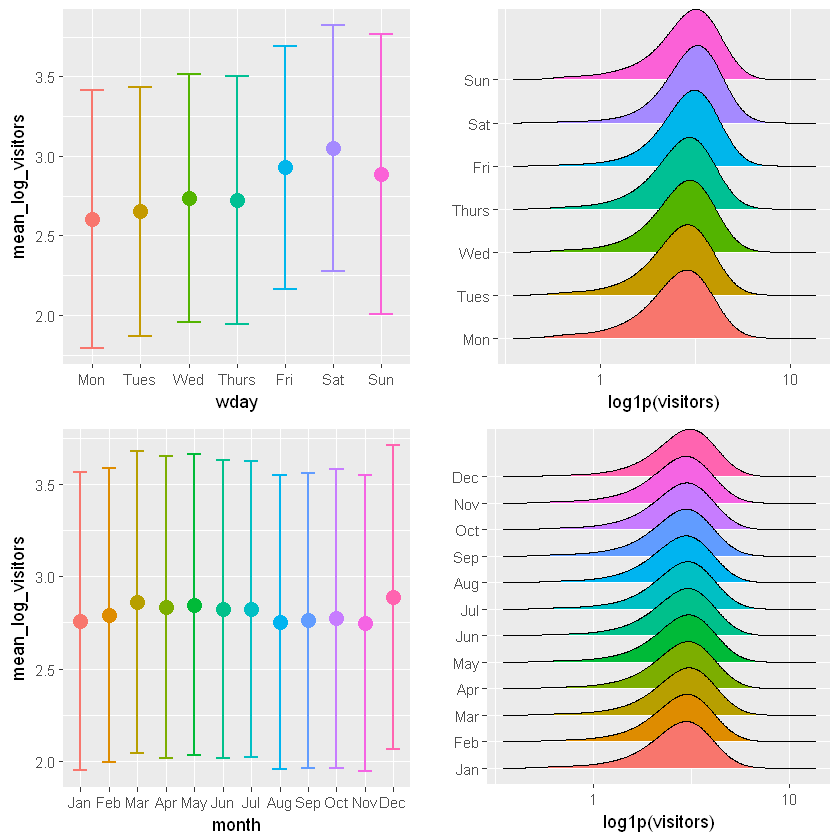

In [82]:
p1 <- air_visits %>%
  group_by(wday) %>%
  summarise(mean_log_visitors = mean(log1p(visitors)),
            sd_log_visitors = sd(log1p(visitors))) %>%
  ggplot(aes(wday, mean_log_visitors, color = wday)) +
  geom_point(size = 4) +
  geom_errorbar(aes(ymin = mean_log_visitor s - sd_log_visitors,
                    ymax = mean_log_visitors + sd_log_visitors,
                    color = wday), width = 0.5, size = 0.7) +
  theme(legend.position = "none")

p2 <- air_visits %>%
  mutate(visitors = log1p(visitors)) %>%
  ggplot(aes(visitors, wday, fill = wday)) +
  geom_density_ridges(bandwidth = 0.1) +
  scale_x_log10() +
  theme(legend.position = "none") +
  labs(x = "log1p(visitors)", y = "")

p3 <- air_visits %>%
  group_by(month) %>%
  summarise(mean_log_visitors = mean(log1p(visitors)),
            sd_log_visitors = sd(log1p(visitors))) %>%
  ggplot(aes(month, mean_log_visitors, color = month)) +
  geom_point(size = 4) +
  geom_errorbar(aes(ymin = mean_log_visitors - sd_log_visitors,
                    ymax = mean_log_visitors + sd_log_visitors,
                    color = month), width = 0.5, size = 0.7) +
  theme(legend.position = "none")

p4 <- air_visits %>%
  mutate(visitors = log1p(visitors)) %>%
  ggplot(aes(visitors, month, fill = month)) +
  geom_density_ridges(bandwidth = 0.1) +
  scale_x_log10() +
  theme(legend.position = "none") +
  labs(x = "log1p(visitors)", y = "")

layout <- matrix(c(1,2,3,4),2,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, layout=layout)


We find:

- Most areas in the *air* data set have only a few restaurants, with the distribution peaking at 2. This goes back to the earlier observation that no single *air\_genre* can ever be found in an *air\_area*. There are always at least 2 of the same type. Still odd. The *air* data also has a tentative 2nd peak around 16-20. The *hpg* data, with larger overall numbers, also peaks at low counts and has few other, smaller peaks through its decline.

- The mean `log1p` visitor numbers per area have large uncertainties and are all consistent with each other. There is a slight trend, shown by the black linear regression, toward lower average numbers for larger areas but it is quite weak. 


## Distance from the busiest area

Whenever we have spatial coordinates in our data we automatically also have the distances between these coordinates. As a first approximation we use the *linear distance* between two points (i.e. as the crow flies).

To compute these distances we are using the *distCosine* function of the [geosphere](https://cran.r-project.org/web/packages/geosphere/index.html) package for spherical trigonometry. This method gives us the shortest distance between two points on a spherical earth. For the purpose of this localised analysis we choose to ignore ellipsoidal distortion of the earth's shape.

As the single reference point for all distances we choose the median latitude and median longitude. Our analysis can be extended to investigate all the pairwise distances between two restaurants with the same methodology. We won't perform this study in our kernel, but I encourage anyone who wants to try it to see whether additional insight can be gained this way. 

Here, we plot the histograms of the distances from the medians for all the restaurants in the *air* and *hpg* data. These distributions will suggest a grouping into 5 different bins with ranges of increasing distance. We then compute the mean `log1p` visitor numbers for the 5 groups and compare them:

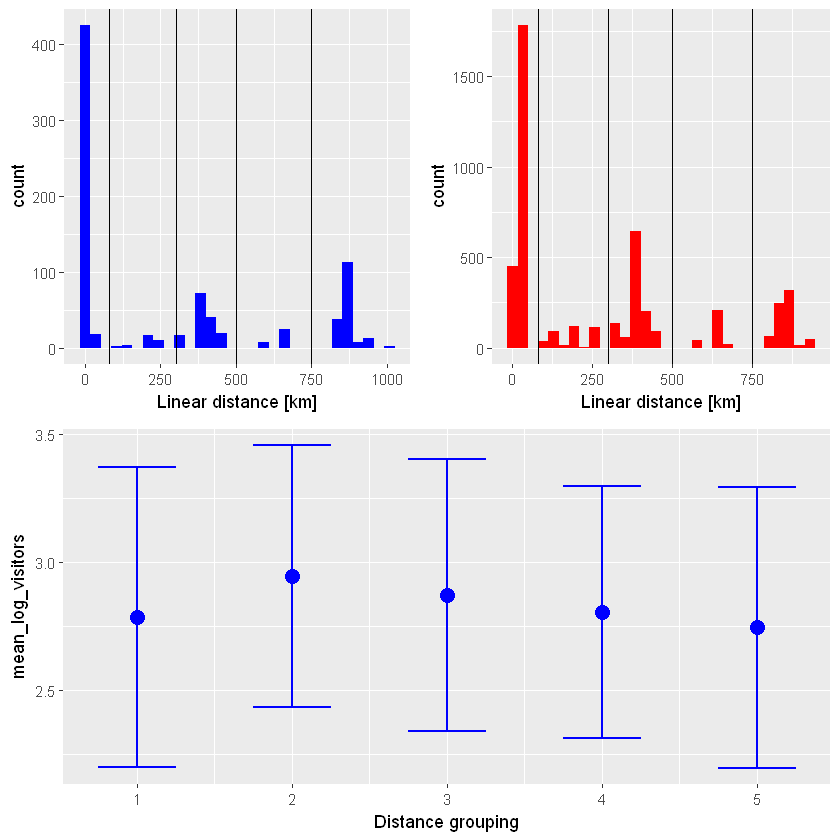

In [83]:
p1 <- air_store %>%
  ggplot(aes(dist)) +
  geom_histogram(bins = 30, fill = "blue") +
  geom_vline(xintercept = c(80, 300, 500, 750)) +
  labs(x = "Linear distance [km]")

p2 <- hpg_store %>%
  ggplot(aes(dist)) +
  geom_histogram(bins = 30, fill = "red") +
  geom_vline(xintercept = c(80, 300, 500, 750)) +
  labs(x = "Linear distance [km]")

p3 <- air_visits %>%
  left_join(air_store, by = "air_store_id") %>%
  group_by(air_store_id, dist_group) %>%
  summarise(mean_store_visit = mean(log1p(visitors))) %>%
  group_by(dist_group) %>%
  summarise(mean_log_visitors = mean(mean_store_visit),
            sd_log_visitors = sd(mean_store_visit)) %>%
  ggplot(aes(dist_group, mean_log_visitors)) +
  geom_point(size = 4, color = "blue") +
  geom_errorbar(aes(ymin = mean_log_visitors - sd_log_visitors,
                    ymax = mean_log_visitors + sd_log_visitors),
                    color = "blue", width = 0.5, size = 0.7) +
  labs(x = "Distance grouping")
  

layout <- matrix(c(1,2,3,3),2,2,byrow=TRUE)
multiplot(p1, p2, p3, layout=layout)

We find:

- The distance distribution has a clear peak at very short values; which is to be expected since our reference is the median. We also see further peaks, most prominently around ~450 km and ~800 km. These will correspond to (groups of) cities and are consistent between the *air* and *hpg* data. We define 5 distance bins based on the vertical black lines at 80, 300, 500, and 750 km.

- The mean `log1p`-transformed visitor counts for these 5 distance bins show no significant differences within their standard deviations.


Here we show a *leaflet* map of the *air* (blue) and *hpg* (red) restaurants, where the size of the circles increases with increasing distance bin relative to the (dark green) centre reference coordinate. Without much surprise, this median location is to be found in Tokyo:

In [85]:
# foo <- air_store %>% select(latitude, longitude, dist_group) %>% mutate(dset = "air")
# bar <- hpg_store %>% select(latitude, longitude, dist_group) %>% mutate(dset = "hpg")

# leaflet(foo) %>%
#   addTiles() %>%
#   addProviderTiles("CartoDB.Positron") %>%
#   addScaleBar() %>%
#   addCircleMarkers(~longitude, ~latitude, group = "AIR",
#                    color = "blue", fillOpacity = 0.5, radius = 3*foo$dist_group) %>%
#   addCircleMarkers(lng = bar$longitude, lat = bar$latitude, group = "HPG",
#                    color = "red", fillOpacity = 0.5, radius = 3*bar$dist_group) %>%
#   addCircleMarkers(lng = med_coord_air$longitude, lat = med_coord_air$latitude, group = "Centre",
#                    color = "darkgreen", fillOpacity = 1) %>%
#   addLayersControl(
#     overlayGroups = c("AIR", "HPG", "Centre"),
#     options = layersControlOptions(collapsed = FALSE)
#   )

## Prefectures

This is a straight-forward feature where we simply define the *prefecture* as the first part of the *area\_name*. Here we make use of the (generally) consistent formatting of the area name as explained by [Oscar Takeshita](https://www.kaggle.com/pliptor) in the [discussion](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/44842#252642) (see a few caveats there). This gives us a relatively small number of distinct high-level areas:


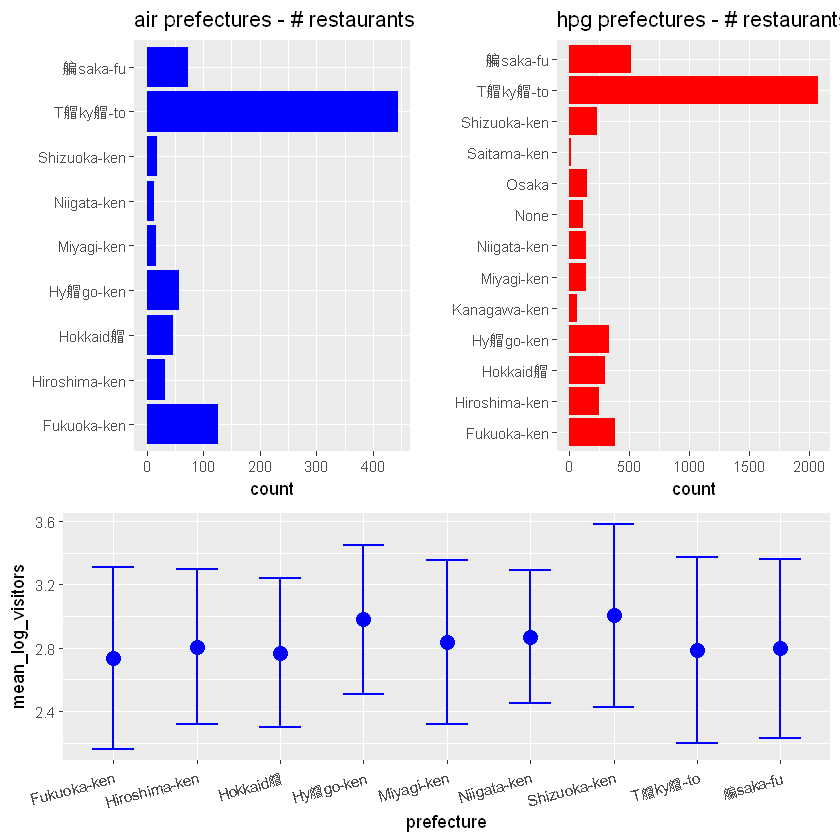

In [86]:
p1 <- air_store %>%
  ggplot(aes(prefecture)) +
  geom_bar(fill = "blue") +
  coord_flip() +
  ggtitle("air prefectures - # restaurants") +
  labs(x = "")

p2 <- hpg_store %>%
  ggplot(aes(prefecture)) +
  geom_bar(fill = "red") +
  coord_flip() +
  ggtitle("hpg prefectures - # restaurants") +
  labs(x = "")

p3 <- air_visits %>%
  left_join(air_store, by = "air_store_id") %>%
  group_by(air_store_id, prefecture) %>%
  summarise(mean_store_visit = mean(log1p(visitors))) %>%
  group_by(prefecture) %>%
  summarise(mean_log_visitors = mean(mean_store_visit),
            sd_log_visitors = sd(mean_store_visit)) %>%
  ggplot(aes(prefecture, mean_log_visitors)) +
  geom_point(size = 4, color = "blue") +
  geom_errorbar(aes(ymin = mean_log_visitors - sd_log_visitors,
                    ymax = mean_log_visitors + sd_log_visitors),
                    color = "blue", width = 0.5, size = 0.7) +
  labs(x = "prefecture") +
  theme(axis.text.x  = element_text(angle=15, hjust=1, vjust=0.9))

layout <- matrix(c(1,2,1,2,1,2,3,3,3,3),5,2,byrow=TRUE)
multiplot(p1, p2, p3, layout=layout)

We find:

- There are 9 prefectures in the *air* data and 13 entries in the *hpg* data. In both data sets "Tokyo" is clearly the most frequent entry.

- Once more, we don't see signficant differences in the mean `log1p` *visitor* numbers for the 9 different *air* prefectures. Any possible variation is smaller than the size of the error bars.


# Time series parameters

After engineering new features based on the geographical or culinary properties of the different restaurants, we will now look directly at the time series of their visitor numbers. With only 829 time series, from 829 *air* restaurants, it is actually easily possible to look at each of them individually, and there are kernels that plot [small](https://www.kaggle.com/roseperrone/plots-for-individual-restaurants) or [large](https://www.kaggle.com/apapiu/visualize-the-time-series) fractions of them to get a feeling for the data.

Here, we will take a different approach and look at the meta parameters of each time series. Those features are the mean, standard deviation, slope, and, slope error of the time series. Each parameter is computed for the `log1p`-transformed data. In the next code block, we define a extraction function and then run it for each restaurant. Due to the small size of the data set this takes almost no time:

In [89]:
foo <- air_visits %>%
  left_join(air_store, by = "air_store_id") %>%
  group_by(air_store_id, air_genre_name) %>%
  summarise(mean_log_visits = mean(log1p(visitors)),
            sd_log_visits = sd(log1p(visitors))) %>%
  ungroup()

params_ts1 <- function(rownr){
  bar <- air_visits %>%
    filter(air_store_id == foo$air_store_id[rownr])
  slope <- summary(lm(visitors ~ visit_date, data = bar))$coef[2]
  slope_err <- summary(lm(visitors ~ visit_date, data = bar))$coef[4]
  
  foobar <- tibble(
    air_store_id = foo$air_store_id[rownr],
    slope = slope,
    slope_err = slope_err
  )
  
  return(foobar)
}

params <- params_ts1(1)
for (i in seq(2,nrow(foo))){
  params <- bind_rows(params, params_ts1(i))
}

ts_params <- foo %>%
  left_join(params, by = "air_store_id")

Now we will plot the parameters and their one-dimensional and two-dimensional distributions:

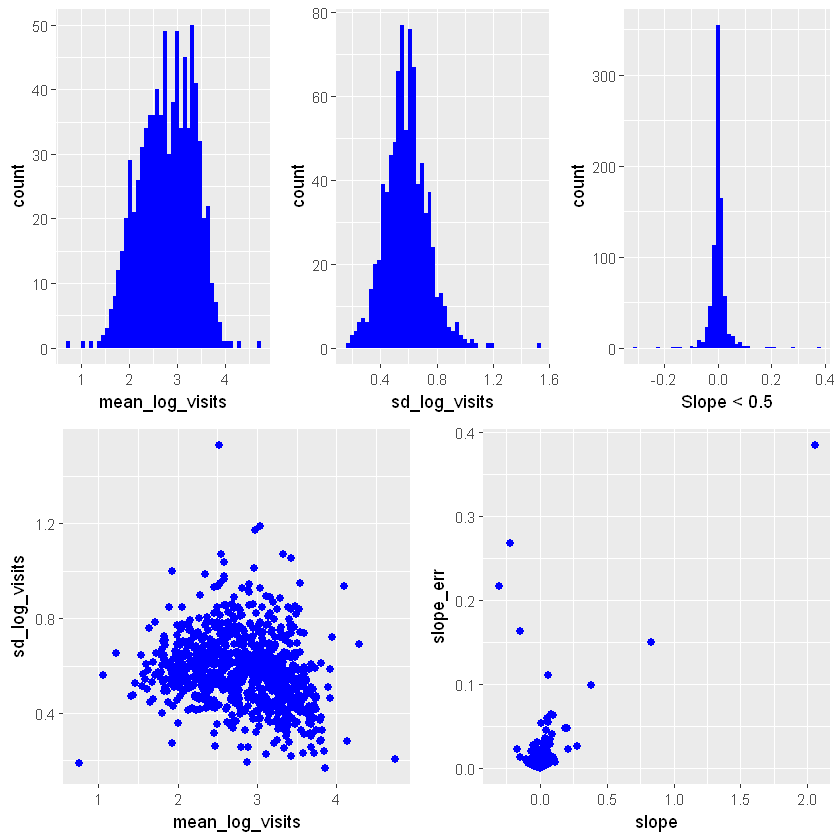

In [103]:
p1 <- ts_params %>%
  ggplot(aes(mean_log_visits)) +
  geom_histogram(bins = 50, fill = "blue")

p2 <- ts_params %>%
  ggplot(aes(sd_log_visits)) +
  geom_histogram(bins = 50, fill = "blue")

p3 <- ts_params %>%
  filter(slope < 0.5) %>%
  ggplot(aes(slope)) +
  geom_histogram(bins = 50, fill = "blue") +
  labs(x = "Slope < 0.5")

p4 <- ts_params %>%
  ggplot((aes(mean_log_visits, sd_log_visits))) +
  geom_point(size = 2, color = "blue")

p5 <- ts_params %>%
  ggplot((aes(slope, slope_err))) +
  geom_point(size = 2, color = "blue")

layout <- matrix(c(1,1,2,2,3,3,4,4,4,5,5,5),2,6,byrow=TRUE)
multiplot(p1, p2, p3, p4, p5, layout=layout)

We find:

- The distributions of the *mean* and *standard deviation* for the `log1p`-transformed visitor counts are relatively broad. I don't think we can assume normality for either of them, although the distributions are relatively symmetric. The shape of the *mean* vs *sd* cloud in the lower left panel support the idea that there is a relation between the two features, with larger average visitor counts having a smaller variance.

- The *slope* distribution is narrow; centred on zero slope. The *slope* vs *slope error* plot in the lower right panel showcases that there are a few outliers with large *slope errors* and mostly high absolute *slope* values:


In [104]:
ts_params %>%
  filter(abs(slope) > 0.25) %>%
  select(air_store_id, air_genre_name, slope, slope_err)

air_store_id,air_genre_name,slope,slope_err
air_1c0b150f9e696a5f,Okonomiyaki/Monja/Teppanyaki,-0.3046967,0.21659798
air_8110d68cc869b85e,Izakaya,0.3824511,0.09843396
air_900d755ebd2f7bbd,Italian/French,2.0550887,0.38504869
air_965b2e0cf4119003,Izakaya,0.2769731,0.02654483
air_9c6787aa03a45586,Cafe/Sweets,0.8324259,0.15013824


Finally, we will have a comprehensive view at the relation between mean `log1p` visitors and the time series slope using a *facet zoom* view, as implemented in the [ggforce package](https://cran.r-project.org/web/packages/ggforce). Here, we will see the full space on the right side and the zoomed-in version on the left side. The zoom region is indicated on the right side with a darker shading. This view is perfect for situations like this, where a few extreme points would make it difficult to focus on the properties of the majority data cluster. The *mean\_log\_visits* and *slope* are plotted coloured by *genre* and with associated errorbars in grey:

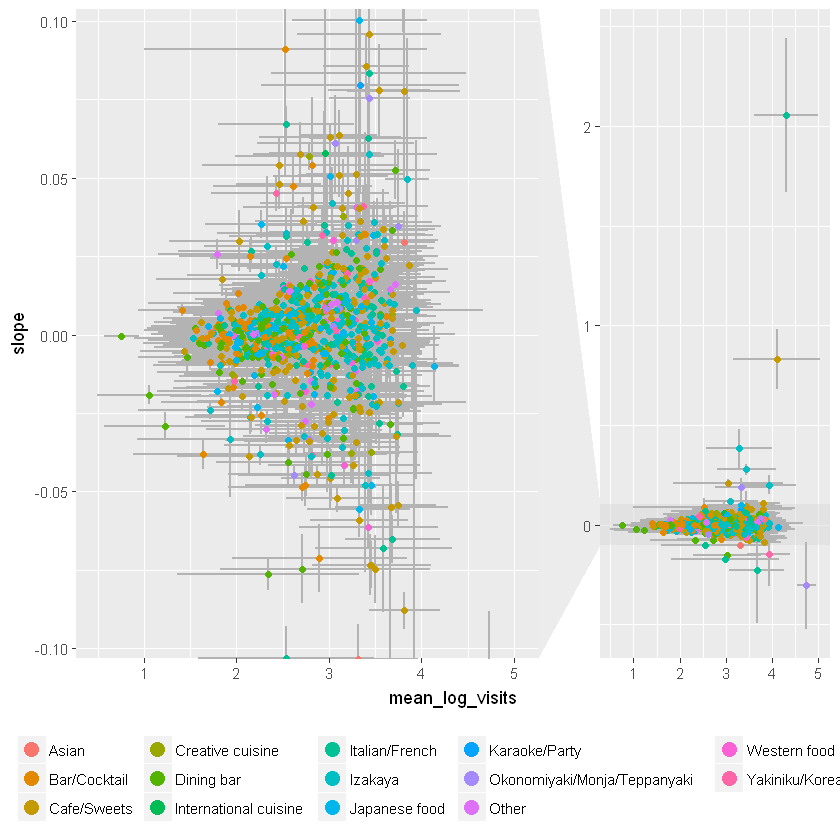

In [105]:
ts_params %>%
  ggplot(aes(mean_log_visits, slope, color = air_genre_name)) +
  geom_errorbarh(aes(xmin = mean_log_visits - sd_log_visits,
                    xmax = mean_log_visits + sd_log_visits),
                    color = "grey70", size = 0.7) +
  geom_errorbar(aes(ymin = slope - slope_err,
                    ymax = slope + slope_err),
                    color = "grey70", size = 0.7) +
  geom_point() +
  theme(legend.position = "bottom") +
  guides(color = guide_legend(nrow = 3, override.aes = list(size = 4))) +
  labs(color = "") +
  facet_zoom(y = (slope < 0.05 & slope > -0.1))

We find:

- There's not a lot of *genre* clustering, although the three points with the lowest mean `log1p` visits are all dining bars, for what it's worth. We find the *slope* outliers in the again in the overview plot and notice that all of them have large *mean* values.

- Both panels show an overall trend for larger *slopes* to be associated to higher *means*. This may not be surprising, since we use he absolute *slope* value with has more range for high *visitor* counts than for low ones. Feel free to plot the *slope* normalised by *mean* to see whether the effect persists.


The extreme values in this plot can now be studied in detail, and we will choose some of them as examples in our next section.


# Forecasting methods and examples

Finally, we will turn our focus to time-series forecasting methods. We have already learnt a lot about our data set and it's features. The following sections will introduce basic forecasting methods. This chapter sets out by borrowing heavily from the explanations and methods outlined in my [WikiTrafficForecast kernel](https://www.kaggle.com/headsortails/wiki-traffic-forecast-exploration-wtf-eda).


## ARIMA / auto.arima

A popular method for forecasting is the *autoregressive integrated moving average* model; short [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model. This kind of model consists of three building blocks which parametrised by the three indeces *p, d, q* as ARIMA(p, d, q):

- **auto-regressive / p:** we are using past data to compute a regression model for future data. The parameter *p* indicates the range of *lags*; e.g. ARIMA(3,0,0) includes *t-1*, *t-2*, and *t-3* values in the regression to compute the value at *t*.

- **integrated / d:** this is a *differencing* parameter, which gives us the number of times we are subtracting the current and the previous values of a time series. Differencing removes the change in a time series in that it stabilises the mean and removes (seasonal) trends. This is necessary since computing the lags (e.g. difference between time *t* and time *t-1*) is most meaningful if large-scale trends are removed. A time series where the variance (or amount of variability) (and the autocovariance) are time-invariant (i.e. don't change from day to day) is called *stationary*.

- **moving average / q:** this parameter gives us the number of previous error terms to include in the regression error of the model.


Here we will be using the `auto.arima` tool which estimates the necessary ARIMA parameters for each individual time series. In order to feed our data to `auto.arima` we need to turn them into a time-series object using the `ts` tool. We will also add a step for cleaning and outlier removal via the `tsclean` function of the [*forecast* package](https://cran.r-project.org/web/packages/forecast/index.html). We have already seen that our data contain a strong weekly cycle, which will be one of the pre-set parameters of our model. We will include this knowledge when transforming our data. Let's set everything up step by step, with comments and explanations, and then turn it into a function. Unhide the code to see how it is implemented.

 
We use the first *air\_store\_id* ("air_ba937bf13d40fb24") as an example.

In [107]:
air_id = "air_ba937bf13d40fb24"

In order to test our prediction, we will forecast for an identical time frame as we are ultimately tasked to predict (Apr 23th - May 31st). Here we automatically extract these 39 days from the length of the *test* prediction range and define it as our "prediction length".

In [108]:
pred_len <- test %>%
  separate(id, c("air", "store_id", "date"), sep = "_") %>%
  distinct(date) %>%
  nrow()

We choose to predict for the last 39 days of our *training* sample. This might not be  Here we compute the upper end of our *training* dates and subtract our "prediction length" from this value to define the start of our validation sample on Mar 14th. We also create a data set of all *visit\_dates* in preparation for many time series having gaps.

In [109]:
max_date <- max(air_visits$visit_date)
split_date <- max_date - pred_len
all_visits <- tibble(visit_date = seq(min(air_visits$visit_date), max(air_visits$visit_date), 1))

Next, we extract the time series for the specific *air\_store\_id*. We transform the *visitors* counts by `log1p` and join the data set of all *visit\_dates*. This gives us a number of `NA` which we fill in with the overall median. The median might not be the best choice here, but it's a sensible starting point. Most time series prediction tools require a sequential time series without gaps; which is what we create in this step.

In [110]:
foo <- air_visits %>%
  filter(air_store_id == air_id)

visits <- foo %>%
  right_join(all_visits, by = "visit_date") %>%
  mutate(visitors = log1p(visitors)) %>%
  replace_na(list(visitors = median(log1p(foo$visitors)))) %>%
  rownames_to_column()

Using this new time series, we now split the data into *training* and *validation* sets.

In [111]:
visits_train <- visits %>% filter(visit_date <= split_date)
visits_valid <- visits %>% filter(visit_date > split_date)

Now comes the fitting part. As said before, we use the `ts` function to create a time series object and the `tsclean` tool to remove outliers. We also add the weekly frequency. The `stepwise` and `approximation` parameter settings mean that the tool performs a more thorough and precise search over all model parameters. This increases the computing time, but for our small data set this doesn't matter much.

In [112]:
arima.fit <- auto.arima(tsclean(ts(visits_train$visitors, frequency = 7)),
                        stepwise = FALSE, approximation = FALSE)

Using the fitted ARIMA model we will `forecast` for our "prediction length". We include confidence intervals.

In [113]:
arima_visits <- arima.fit %>% forecast(h = pred_len, level = c(50,95))

Finally, we plot our prediction. The `autoplot` function of the `ggplot2` package creates plots according to the properties of a particular data type; here a time series object. The predicted *visitor* counts are shown in dark blue, with the lighter blues indicating the confidence ranges. We also add the real validation counts in grey:

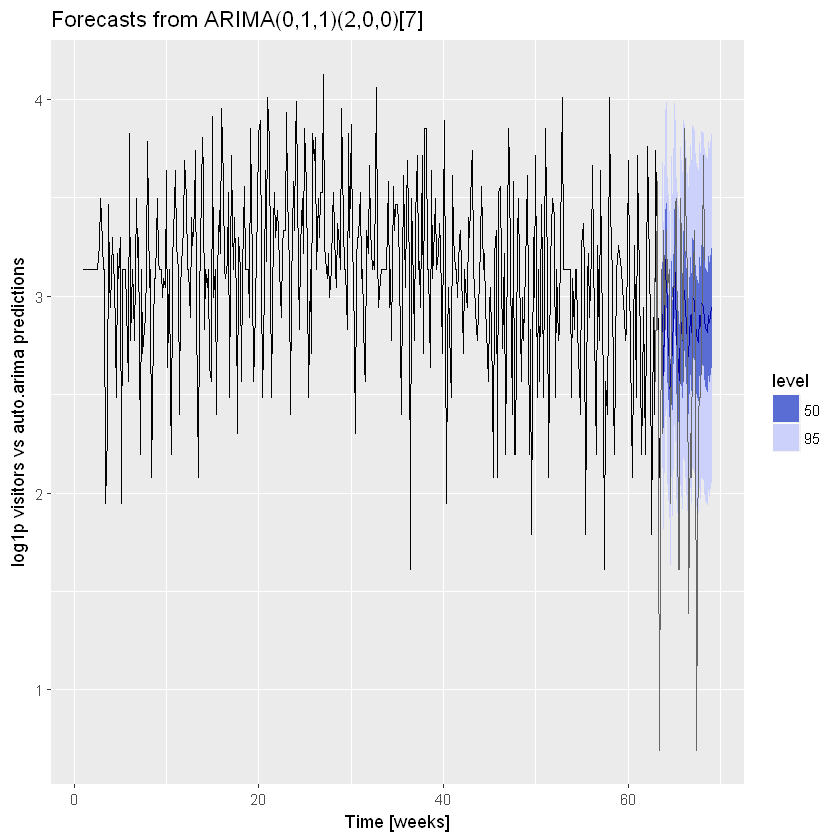

In [114]:
arima_visits %>%
  autoplot +
  geom_line(aes(as.integer(rowname)/7, visitors), data = visits_valid, color = "grey40") +
  labs(x = "Time [weeks]", y = "log1p visitors vs auto.arima predictions")

We find that the first days of the forecast fit quite well, but then our prediction is not able to capture the larger spikes. Still, it's a useful starting point to compare other methods to.


Now we turn this procedure into a function, including the plotting part.


In [116]:
plot_auto_arima_air_id <- function(air_id){

  pred_len <- test %>%
    separate(id, c("air", "store_id", "date"), sep = "_") %>%
    distinct(date) %>%
    nrow()

  max_date <- max(air_visits$visit_date)
  split_date <- max_date - pred_len
  all_visits <- tibble(visit_date = seq(min(air_visits$visit_date), max(air_visits$visit_date), 1))
  
  foo <- air_visits %>%
    filter(air_store_id == air_id)

  visits <- foo %>%
    right_join(all_visits, by = "visit_date") %>%
    mutate(visitors = log1p(visitors)) %>%
    replace_na(list(visitors = median(log1p(foo$visitors)))) %>%
    rownames_to_column()
  
  visits_train <- visits %>% filter(visit_date <= split_date)
  visits_valid <- visits %>% filter(visit_date > split_date)

  arima.fit <- auto.arima(tsclean(ts(visits_train$visitors, frequency = 7)),
                          stepwise = FALSE, approximation = FALSE)

  arima_visits <- arima.fit %>% forecast(h = pred_len, level = c(50,95))

  arima_visits %>%
    autoplot +
    geom_line(aes(as.integer(rowname)/7, visitors), data = visits_valid, color = "grey40") +
    labs(x = "Time [weeks]", y = "log1p visitors vs forecast")
    }

And we apply this function to a few time series', including two of the *slope* outliers from the previous section:

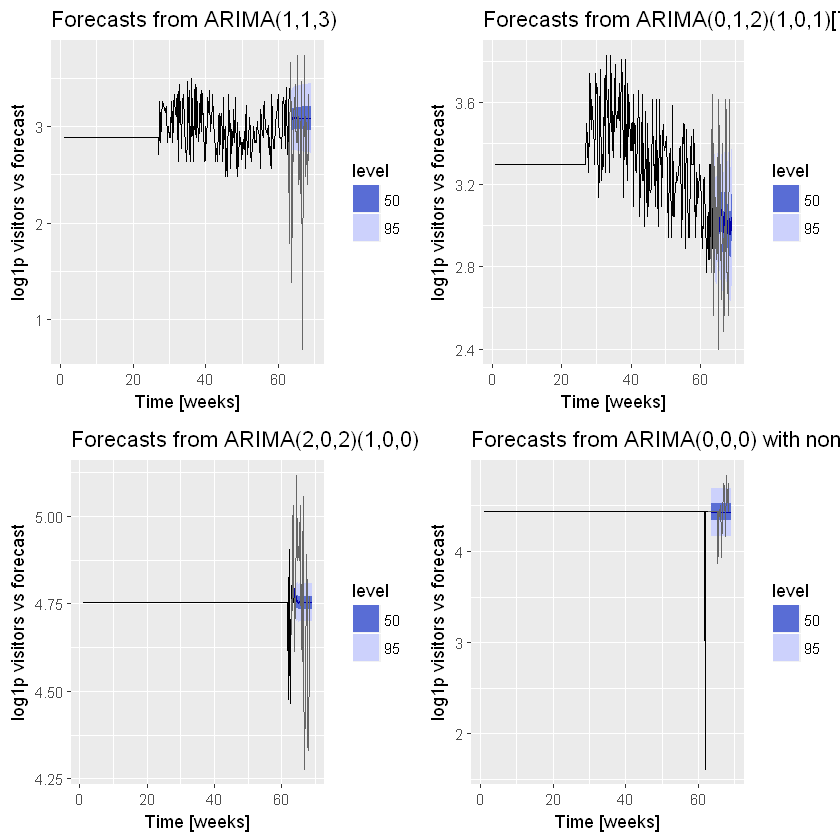

In [117]:
p1 <- plot_auto_arima_air_id("air_f3f9824b7d70c3cf")
p2 <- plot_auto_arima_air_id("air_8e4360a64dbd4c50")
p3 <- plot_auto_arima_air_id("air_1c0b150f9e696a5f")
p4 <- plot_auto_arima_air_id("air_900d755ebd2f7bbd")

layout <- matrix(c(1,2,3,4),2,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, layout=layout)

We find:

- The two time series' in the upper panels are reasonable complete, but we see that the long gaps (and our median filling) lead to problems in the predictions in the upper left panel where we loose the weekly periodicity. The upper right panel retains this periodicity and the predictions for the first days are relatively decent, but then we quickly under-predict the amplitude of the variations.

- The lower panels include two of the outliers from our time-series parameter space above; and here we see cases where things go really wrong. These kind of peculiar time series could lead to a bad performance for any otherwise decent forecasting algorithm if they contain a large enough fraction of visits in the test data set.


Overall, the results are not great, but given that it's a fully automatic forecast (assuming only weekly periodicities) the `auto.arima` tool gives us a first baseline to compare other methods to.


For a more detailed exploration of ARIMA models take a look at [this Kernel](https://www.kaggle.com/timolee/feeling-hungry-a-beginner-s-guide-to-arima-models) by [TimLee](https://www.kaggle.com/timolee).


## Prophet

The [prophet](https://facebookincubator.github.io/prophet/) forecasting tool is an open-source software developed by [Facebook](https://research.fb.com/prophet-forecasting-at-scale/). It is available for both *R* and Python.

Prophet utilises an additive regression model which decomposes a time series into (i) a (piecewise) linear/logistic trend, (ii) a yearly seasonal component, (iii) a weekly seasonal component, and (iv) an optional list of important days (such as holidays, special events, ...). It claims to be "robust to missing data, shifts in the trend, and large outliers". Especially the missing data functionality could be useful in this competition.

Let's again explore the tool step by step. We will build on our work in the ARIMA section and won't repeat any explanations that can be found there.

We will again create a *training* and *validation* set for the same periods as above (i.e before/after Mar 14th). The only differences to our ARIMA approach are that: 

- We don't need to replace `NA` values because prophet knows how to handle those.

- Prophet expects a data frame with two columns: *ds* for the dates and *y* for the time series variable.

In [118]:
air_id = "air_ba937bf13d40fb24"

pred_len <- test %>%
  separate(id, c("air", "store_id", "date"), sep = "_") %>%
  distinct(date) %>%
  nrow()

max_date <- max(air_visits$visit_date)
split_date <- max_date - pred_len
all_visits <- tibble(visit_date = seq(min(air_visits$visit_date), max(air_visits$visit_date), 1))

foo <- air_visits %>%
  filter(air_store_id == air_id)

visits <- foo %>%
  right_join(all_visits, by = "visit_date") %>%
  mutate(visitors = log1p(visitors)) %>%
  rownames_to_column() %>%
  select(y = visitors,
         ds = visit_date)

visits_train <- visits %>% filter(ds <= split_date)
visits_valid <- visits %>% filter(ds > split_date)

ere we fit the prophet model and make the forecast:

- the parameter *changepoint.prior.scale* adjusts the trend flexibility. Increasing this parameter makes the fit more flexible, but also increases the forecast uncertainties and makes it more likely to overfit to noise. The changepoints in the data are automatically detected unless being specified by hand using the *changepoints* argument (which we don't do here).

- the parameter *yearly.seasonality* has to be enabled/disabled explicitely and allows prophet to notice large-scale cycles. We have barely a year of data here, which is definitely insufficient to find yearly cycles and probably not enough to identify variations on the time scales of months. Feel free to test the performance of this parameter. 


In [119]:
proph <- prophet(visits_train, changepoint.prior.scale=0.5, yearly.seasonality=FALSE)
future <- make_future_dataframe(proph, periods = pred_len)
fcast <- predict(proph, future)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -7.65901
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


This is the standard prophet forecast plot:

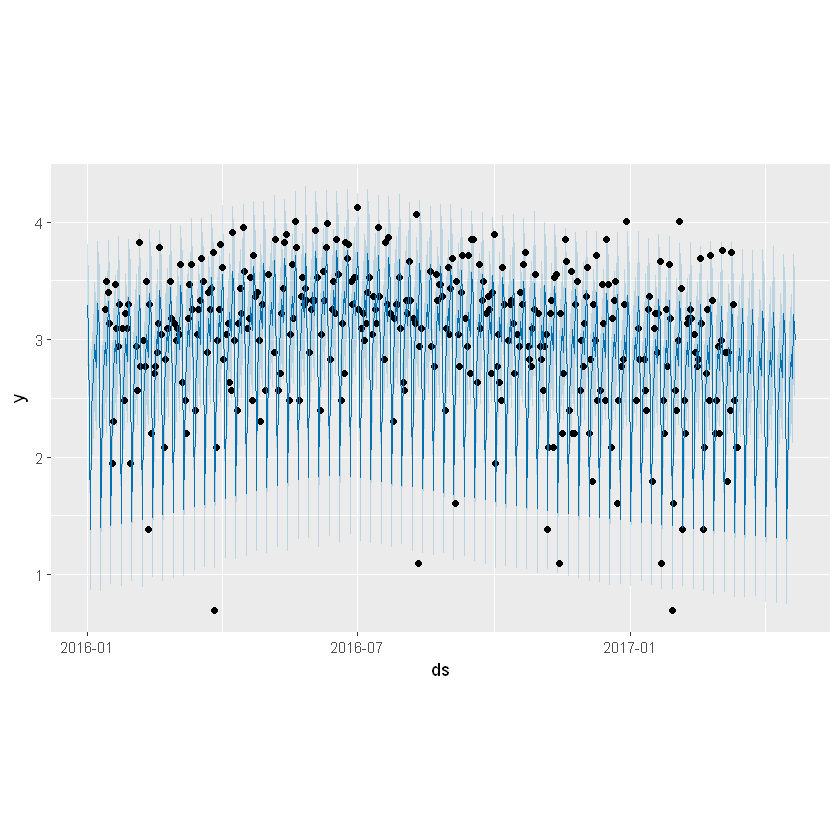

In [120]:
plot(proph, fcast)

The observed data are plotted as black points and the fitted model, plus forecast, as a blue line. In light blue we see the corresponding uncertainties.

Prophet offers a decomposition plot, where we can inspect the additive components of the model: trend, yearly seasonality (if included), and weekly cycles:

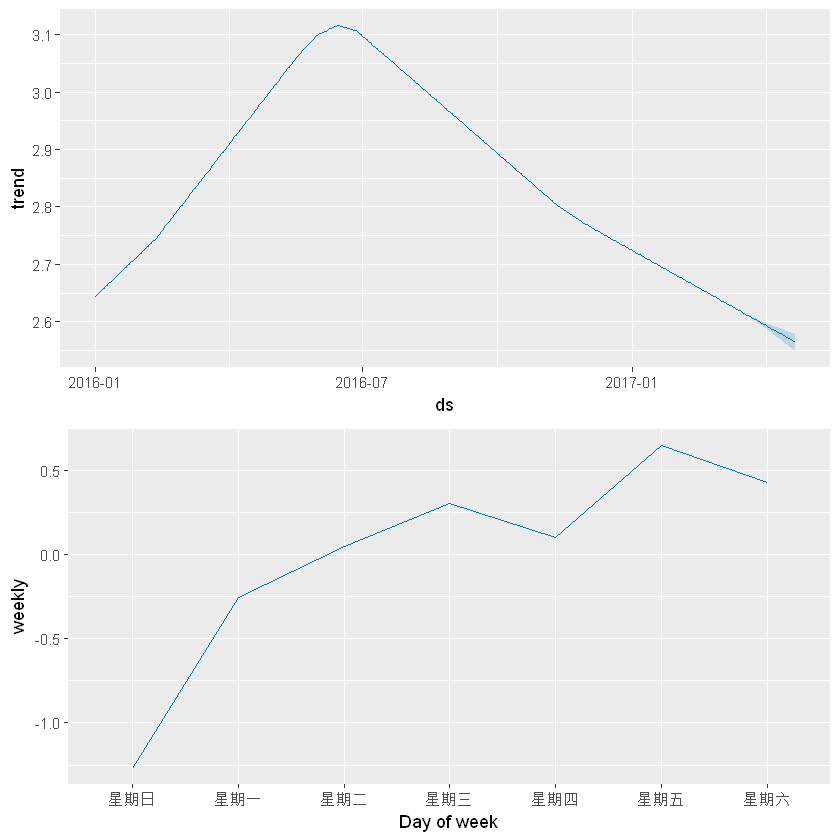

In [121]:
prophet_plot_components(proph, fcast)

We find:

- Prophet detects a weekly variation pattern which is similar to what we had found before, in that Fri/Sat are more popular than the rest of the week. The difference, however, is that here Sun has a very low average *visitor* count. This might be be due to the properties of this particular restaurant, a "Dining Bar" in "Tokyo". In Fig. 23 we see that "Dining Bars" in general are not as busy on Sundays; although not to such a large extent as we see in this graph. The difference in *visitors* on Sat vs Sun might be an interesting feature of an eventual model.

- The long-term trend is different from the average behaviours displayed in Fig. 11, which were more likely to rise toward the end of 2016. Here we see a peak in mid 2016. (Thanks to [GAVOILLEGuillaume](https://www.kaggle.com/guillaumegavoille) in the comments for spotting my earlier mistakes in this description!)

- Note, that this is one specific time series. I've checked other time series as well and many of them showed the expected Fri/Sat/Sun vs Mon-Thu variations along with a long-term peak around Dec 2017. Feel free to fork this Kernel and check for yourself.


So: This is a good start, but we will of course use our trusted `ggplot2` to give us more control over the plotting parameters:


Warning message:
"Removed 12 rows containing missing values (geom_path)."

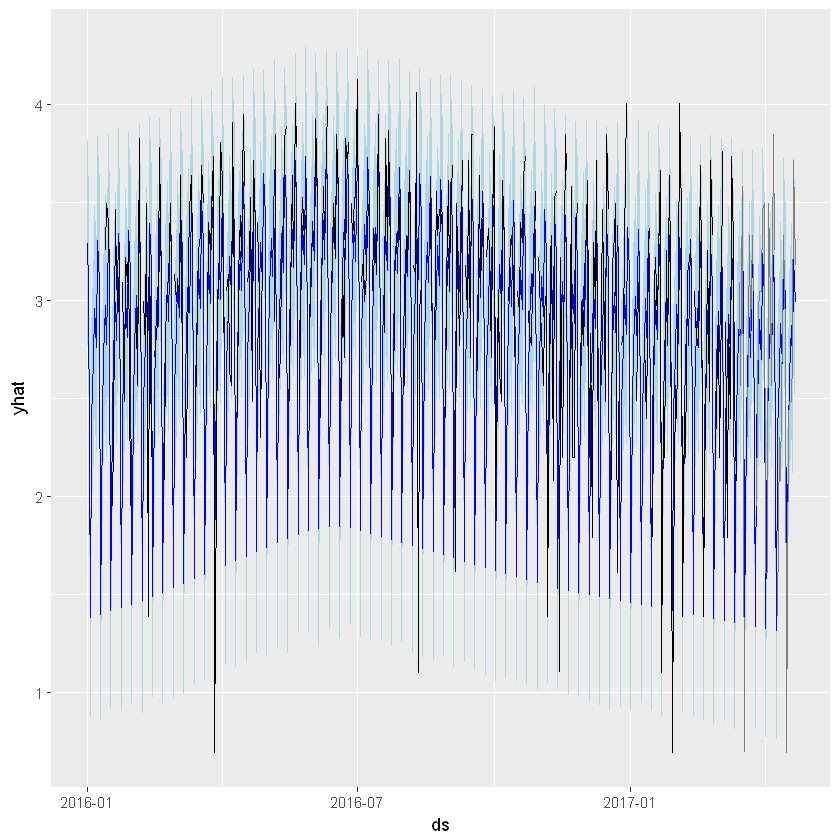

In [122]:
fcast %>%
  as.tibble() %>%
  mutate(ds = date(ds)) %>%
  ggplot(aes(ds, yhat)) + 
  geom_ribbon(aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "light blue") +
  geom_line(colour = "blue") +
  geom_line(data = visits_train, aes(ds, y), colour = "black") +
  geom_line(data = visits_valid, aes(ds, y), colour = "grey50")

That doesn't look too bad. We plot our training visitor counts in black, the validation set in grey, and the forecast plus uncertainties in blue and light blue, again.

Let's turn this into another function:


In [123]:
plot_prophet_air_id <- function(air_id){
  
  pred_len <- test %>%
    separate(id, c("air", "store_id", "date"), sep = "_") %>%
    distinct(date) %>%
    nrow()

  max_date <- max(air_visits$visit_date)
  split_date <- max_date - pred_len
  all_visits <- tibble(visit_date = seq(min(air_visits$visit_date), max(air_visits$visit_date), 1))

  foo <- air_visits %>%
    filter(air_store_id == air_id)

  visits <- foo %>%
    right_join(all_visits, by = "visit_date") %>%
    mutate(visitors = log1p(visitors)) %>%
    rownames_to_column() %>%
    select(y = visitors,
          ds = visit_date)

  visits_train <- visits %>% filter(ds <= split_date)
  visits_valid <- visits %>% filter(ds > split_date)
  
  proph <- prophet(visits_train, changepoint.prior.scale=0.5, yearly.seasonality=FALSE)
  future <- make_future_dataframe(proph, periods = pred_len)
  fcast <- predict(proph, future)
  
  p <- fcast %>%
    as.tibble() %>%
    mutate(ds = date(ds)) %>%
    ggplot(aes(ds, yhat)) +
    geom_ribbon(aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "light blue") +
    geom_line(colour = "blue") +
    geom_line(data = visits_train, aes(ds, y), colour = "black") +
    geom_line(data = visits_valid, aes(ds, y), colour = "grey50") +
    labs(title = str_c("Prophet for ", air_id))
  
  return(p)
}  

And then we forecast and plot the same time series as above (except for "air_900d755ebd2f7bbd", which didn't have enough data points for prophet and had to be replaced by "air_820d1919cbecaa0a"):

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -6.90663
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -3.10721
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.
Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.
n.changepoints greater than number of observations. Using 9


Initial log joint probability = -2.02263
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


Warning message in .local(object, ...):
"non-zero return code in optimizing"Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -2.61361
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Removed 182 rows containing missing values (geom_path)."Warning message:
"Removed 182 rows containing missing values (geom_path)."Warning message:
"Removed 426 rows containing missing values (geom_path)."Warning message:
"Removed 182 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_path)."

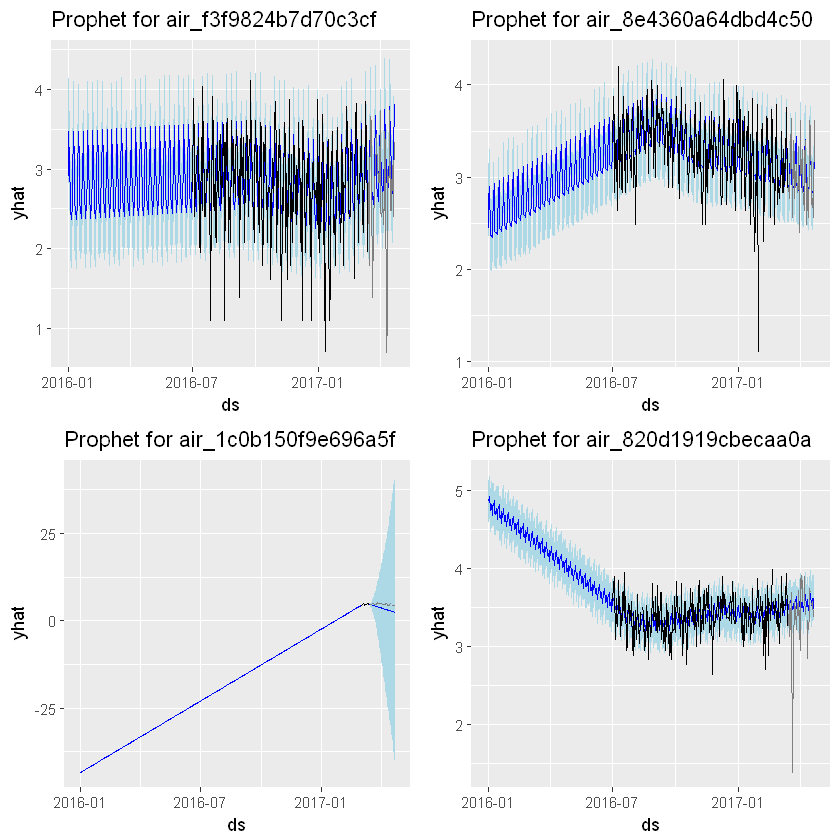

In [124]:
p1 <- plot_prophet_air_id("air_f3f9824b7d70c3cf")
p2 <- plot_prophet_air_id("air_8e4360a64dbd4c50")
p3 <- plot_prophet_air_id("air_1c0b150f9e696a5f")
p4 <- plot_prophet_air_id("air_820d1919cbecaa0a")

layout <- matrix(c(1,2,3,4),2,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, layout=layout)

That looks not bad either. Looks like we're overestimating the trend component, which could probably use less flexibility, for at least three of these. The forth time series has too little data for prophet to be able to do much. Here we could discard the trend component completely or simply take the median.


Remember that prophet also gives us the possibility to include *holidays* and other special events in our forecast. For our task, this could be very useful in taking the Golden Week into account. For more insights from a tailored analysis of the Golden Week's impact have a look at [this kernel](https://www.kaggle.com/breakfastpirate/weeks-before-after-golden-week-2016) by [BreakfastPirate](https://www.kaggle.com/breakfastpirate) and the associated [discussion](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/45048) [topics](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/45120).

Since the holiday data is readily available in this competition we only need to rename it according to prophet's liking to include it in our forecast function. Let's modify that function see whether holidays make a difference when predicting for the 2016 Golden Week. The only thing we need to do is to truncate our *air\_visits* data on May 31 2016 in an intermediate step:


In [125]:
plot_prophet_air_id_holiday <- function(air_id, use_hday){
  
  air_visits_cut <- air_visits %>%
    filter(visit_date <= ymd("20160531"))
  
  hday <- holidays %>%
    filter(holiday_flg == TRUE) %>%
    mutate(holiday = "holiday") %>%
    select(ds = date, holiday)
  
  pred_len <- test %>%
    separate(id, c("air", "store_id", "date"), sep = "_") %>%
    distinct(date) %>%
    nrow()

  max_date <- max(air_visits_cut$visit_date)
  split_date <- max_date - pred_len
  all_visits <- tibble(visit_date = seq(min(air_visits_cut$visit_date), max(air_visits_cut$visit_date), 1))

  foo <- air_visits_cut %>%
    filter(air_store_id == air_id)

  visits <- foo %>%
    right_join(all_visits, by = "visit_date") %>%
    mutate(visitors = log1p(visitors)) %>%
    rownames_to_column() %>%
    select(y = visitors,
          ds = visit_date)

  visits_train <- visits %>% filter(ds <= split_date)
  visits_valid <- visits %>% filter(ds > split_date)
  
  if (use_hday == TRUE){
    proph <- prophet(visits_train,
                     changepoint.prior.scale=0.5,
                     yearly.seasonality=FALSE,
                     holidays = hday)
    ptitle = "Prophet (w/ holidays) for "
  } else {
     proph <- prophet(visits_train,
                     changepoint.prior.scale=0.5,
                     yearly.seasonality=FALSE)
    ptitle = "Prophet for "
  }
  
  future <- make_future_dataframe(proph, periods = pred_len)
  fcast <- predict(proph, future)
  
  p <- fcast %>%
    as.tibble() %>%
    mutate(ds = date(ds)) %>%
    ggplot(aes(ds, yhat)) +
    geom_ribbon(aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "light blue") +
    geom_line(colour = "blue") +
    geom_line(data = visits_train, aes(ds, y), colour = "black") +
    geom_line(data = visits_valid, aes(ds, y), colour = "grey50") +
    labs(title = str_c(ptitle, air_id))
  
  return(p)
}  

And then we take a well behaved time series and compare the predictions with and without holidays:

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -3.79162
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -3.79162
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 1 rows containing missing values (geom_path)."

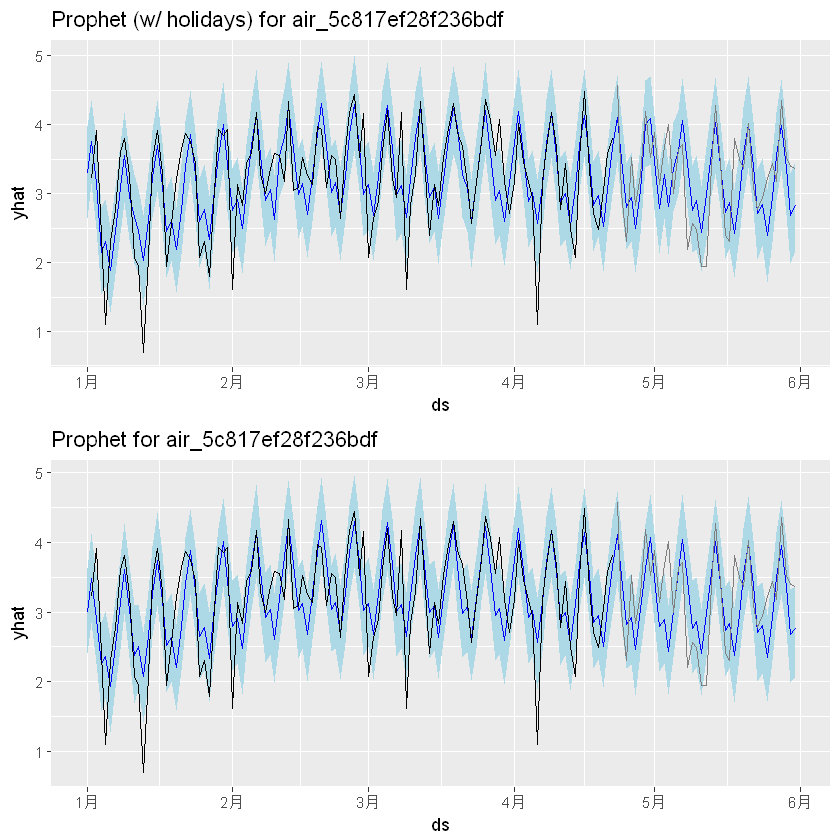

In [126]:
p1 <- plot_prophet_air_id_holiday("air_5c817ef28f236bdf", TRUE)
p2 <- plot_prophet_air_id_holiday("air_5c817ef28f236bdf", FALSE)

layout <- matrix(c(1,2),2,1,byrow=TRUE)
multiplot(p1, p2, layout=layout)

We find:

- There is a subtle improvement in fitting the Golden Week *visitors* when including holidays. The performance of this component might improve if there are more holidays included in the *training* set; but I think it's difficult to validate this.


## Holt-Winters

A more traditional time series filtering and forecasting is the *Holt-Winters* algorithm, as implemented in the [`stats` package](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/HoltWinters.html). This is an exponential smoothing method which uses moving averages to take into account the presence of a trend in the data. Here we define a default seasonal model in a fitting and plotting function:


In [127]:
plot_hw_air_id <- function(air_id){

  pred_len <- test %>%
    separate(id, c("air", "store_id", "date"), sep = "_") %>%
    distinct(date) %>%
    nrow()

  max_date <- max(air_visits$visit_date)
  split_date <- max_date - pred_len
  all_visits <- tibble(visit_date = seq(min(air_visits$visit_date), max(air_visits$visit_date), 1))

  foo <- air_visits %>%
    filter(air_store_id == air_id)

  visits <- foo %>%
    right_join(all_visits, by = "visit_date") %>%
    mutate(visitors = log1p(visitors)) %>%
    replace_na(list(visitors = median(log1p(foo$visitors)))) %>%
    rownames_to_column()

  visits_train <- visits %>% filter(visit_date <= split_date)
  visits_valid <- visits %>% filter(visit_date > split_date)

  hw.fit <- HoltWinters(tsclean(ts(visits_train$visitors, frequency = 7)))

  hw_visits <- predict(hw.fit, n.ahead = pred_len, prediction.interval = T, level = 0.95) %>%
    as.tibble() %>%
    bind_cols(visits_valid)

  visits_train %>%
    ggplot(aes(visit_date, visitors)) +
    geom_line() +
    geom_ribbon(data = hw_visits, aes(x = visit_date, ymin = lwr, ymax = upr), fill = "light blue") +
    geom_line(data = hw_visits, aes(visit_date, visitors), color = "grey60") +
    geom_line(data = hw_visits, aes(visit_date, fit), color = "blue") +
    geom_line(data = hw_visits, aes(visit_date, fit), color = "blue") +
    labs(x = "Time [weeks]", y = "log1p visitors vs predictions") +
    ggtitle("HoltWinters")
}

We then apply this function to our example time series:


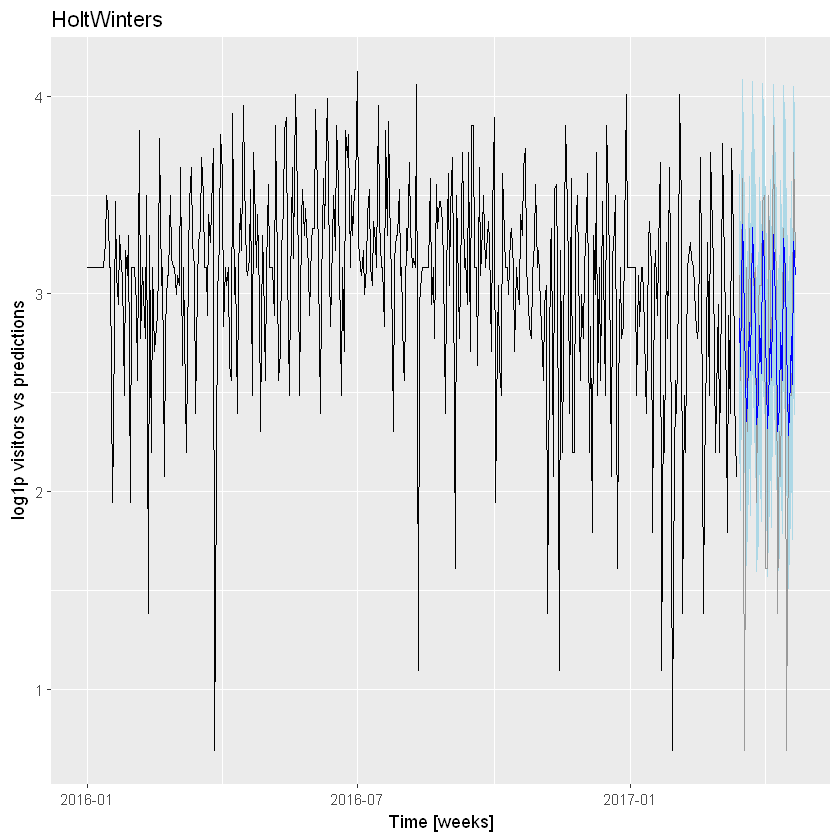

In [128]:
plot_hw_air_id("air_ba937bf13d40fb24")

And also plot the same predictions as for *prophet* above:

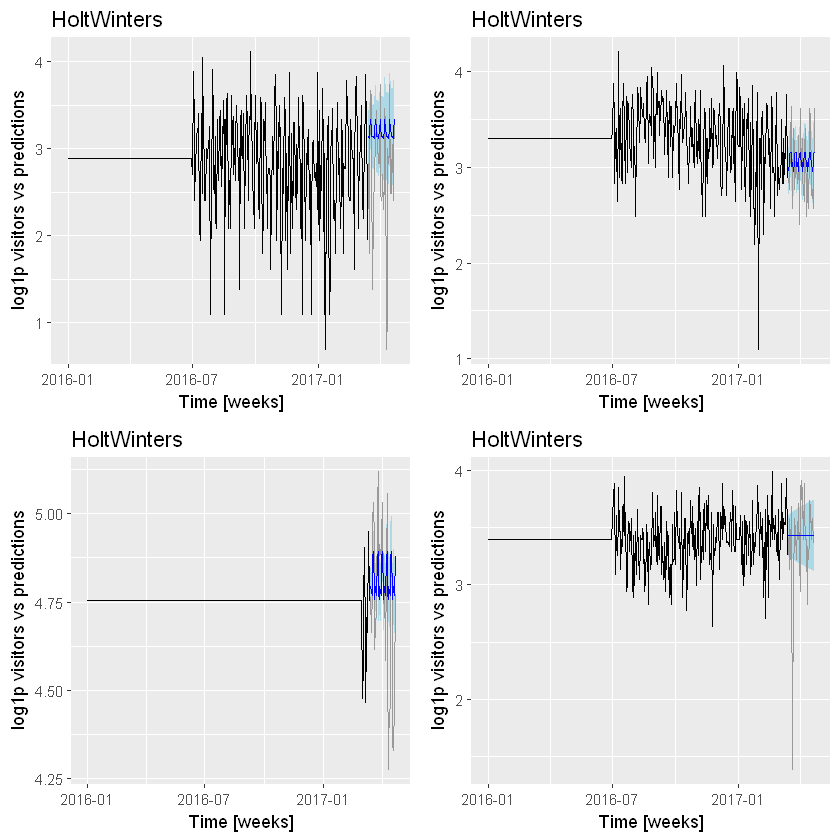

In [129]:
p1 <- plot_hw_air_id("air_f3f9824b7d70c3cf")
p2 <- plot_hw_air_id("air_8e4360a64dbd4c50")
p3 <- plot_hw_air_id("air_1c0b150f9e696a5f")
p4 <- plot_hw_air_id("air_820d1919cbecaa0a")

layout <- matrix(c(1,2,3,4),2,2,byrow=TRUE)
multiplot(p1, p2, p3, p4, layout=layout)

We find:

- While the algorithm performs reasonably well with sufficient data given, similar to `auto.arima` it breaks down for special cases of missing data. We might get a better performance by discarding the missing values instead of replacing them with the median. However, the first impression looks less promising than the `prophet` approach.

- Feel free to fork this kernel and experiment with modified additive and exponential models to tweak the performance of the Holt-Winters method.


---

To be continued.